# Proyecto
## Algoritmo Genético para la resolución de sudoku

Carrera: Ingenieria en Inteligencia Artificial

Alumnos:

* Padilla Matias Cristian Michel
* Saucillo Gonzalez Jesse Obed
* Vázquez Arana Frida Fernanda

Grupo: 5BM2

In [ ]:
import numpy as np
import random
import random
import numpy as np
import matplotlib.pyplot as plt

def inicializarIndividuo(plantilla):
    """ Inicializa un individuo basado en una plantilla dada.
        Rellena los ceros con números aleatorios del 1 al 9 sin repetir en cada fila."""
    individuo = np.array(plantilla, dtype=int).copy()

    for fila in range(9):
        # Encontrar los números que ya están en la fila
        existentes = set(individuo[fila]) - {0}
        # Encontrar los números que faltan en la fila
        faltantes = list(set(range(1, 10)) - existentes)
        random.shuffle(faltantes)

        # Rellenar los ceros con los números faltantes
        idx = 0
        for col in range(9):
            if individuo[fila][col] == 0:
                individuo[fila][col] = faltantes[idx]
                idx += 1

    return individuo

def inicializarPoblacion(plantilla, tamanPoblacion):
    """ Inicializa una población de Sudokus basada en una plantilla dada."""
    poblacion = [inicializarIndividuo(plantilla) for _ in range(tamanPoblacion)]
    return poblacion

def contarRepetidos(lista):
    """ Cuenta los números repetidos en una lista de 9 elementos."""
    repetidos = 0
    contador = [0] * 10  # Cada elemento asume el conteo de los números del 1 al 9
    for num in lista:
        if num != 0:
            contador[num] += 1
            if contador[num] > 1:
                repetidos += 1
    return repetidos

def funcionObjetivo(sudoku):
    """ Calcula la función objetivo para un Sudoku 9x9.
        Cuenta el total de números repetidos en filas, columnas y regiones 3x3."""
    repetidos_totales = 0

    # Repeticiones en filas
    for fila in sudoku:
        repetidos_totales += contarRepetidos(fila)

    # Repeticiones en columnas
    for col in range(9):
        columna = [sudoku[fila][col] for fila in range(9)]
        repetidos_totales += contarRepetidos(columna)

    # Repeticiones en regiones 3x3
    for i in range(3):
        for j in range(3):
            region = []
            for k in range(3):
                for l in range(3):
                    region.append(sudoku[i*3+k][j*3+l])
            repetidos_totales += contarRepetidos(region)

    return repetidos_totales

def cruza1Punto(padre1, padre2):
    """ Realiza la cruza de dos individuos (padres) para producir dos hijos.
        Cada hijo toma algunas filas de un padre y otras filas del otro padre. """
    hijo1 = np.zeros((9, 9), dtype=int)
    hijo2 = np.zeros((9, 9), dtype=int)

    # Generar un punto de cruza
    punto_cruza = random.randint(1, 8)  # Elegir un punto de cruza entre 1 y 8

    # Crear el primer hijo
    hijo1[:punto_cruza] = padre1[:punto_cruza]
    hijo1[punto_cruza:] = padre2[punto_cruza:]

    # Crear el segundo hijo
    hijo2[:punto_cruza] = padre2[:punto_cruza]
    hijo2[punto_cruza:] = padre1[punto_cruza:]

    return hijo1, hijo2

def cruzaPorFilas(padre1, padre2, rowCrossverRate=0.7):
    """ Realiza la cruza de dos individuos (padres) para producir dos hijos.
        Se recorre cada fila de los padres y se genera un número random, si el número
        es mayor al umbral, la fila se intercambia. """
    hijo1 = np.array(padre1, dtype=int).copy()
    hijo2 = np.array(padre2, dtype=int).copy()

    for fila in range(9):
        if  random.random() > rowCrossverRate:
            # Intercambiar la fila entre los dos hijos
            hijo1[fila], hijo2[fila] = hijo2[fila].copy(), hijo1[fila].copy()

    return hijo1, hijo2

def mutacionIntercambio(individuo, plantilla, swapMutationRate=0.8):
    """ Realiza la mutación de un individuo.
    Intercambia dos números al azar en una fila con una probabilidad dada,
    asegurando no modificar las celdas fijas de la plantilla. """
    for fila in range(9):
        if random.random() < swapMutationRate:
            # Encuentra las columnas que no son fijas en una fila random
            columnas = [col for col in range(9) if plantilla[fila][col] == 0]
            if len(columnas) > 1:
                col1, col2 = random.sample(columnas, 2)
                individuo[fila][col1], individuo[fila][col2] = individuo[fila][col2], individuo[fila][col1]
    return individuo

def reinicializarFila(fila, plantilla_fila):
    """ Inicializa una fila del Sudoku basada en una plantilla dada.
        Rellena los ceros con números aleatorios del 1 al 9 sin repetir. """
    individuo_fila = np.array(fila, dtype=int).copy()

    # Encontrar los números que ya están en la fila
    existentes = set(individuo_fila) - {0}
    # Encontrar los números que faltan en la fila
    faltantes = list(set(range(1, 10)) - existentes)
    random.shuffle(faltantes)

    # Rellenar los ceros con los números faltantes
    idx = 0
    for col in range(9):
        if plantilla_fila[col] == 0:
            individuo_fila[col] = faltantes[idx]
            idx += 1

    return individuo_fila

def mutacionReinicializacion(individuo, plantilla, reinitializationMutationRate=0.4):
    """ Realiza la mutación de reinicialización de filas en un individuo.
        Si el número random es menor a un umbral, reinicializa todos los elementos
        de esa fila excepto los números fijos. """
    for fila in range(9):
        if random.random() < reinitializationMutationRate:
            individuo[fila] = reinicializarFila(individuo[fila], plantilla[fila])
    return individuo

def encontrarIndicesRepetidos(lista):
    indice_por_valor = {}
    for indice, valor in enumerate(lista):
        if valor in indice_por_valor:
            return [indice_por_valor[valor], indice]
        else:
            indice_por_valor[valor] = indice
    return None

def encontrarColumnasIlegales(individuo):
    """ Encuentra las columnas ilegales (con números repetidos) en un Sudoku. """
    columnas_ilegales = []
    for col in range(9):
        columna = individuo[:, col]
        if len(columna) != len(set(columna)):  # Hay números repetidos
            columnas_ilegales.append([col, encontrarIndicesRepetidos(columna)])
    return columnas_ilegales

def busquedaLocal(individuo):
    columnasIlegales = encontrarColumnasIlegales(individuo)
    individuoColumnas = [list(col) for col in zip(*individuo)]
    plantilla = individuo.copy()  # Guardar la plantilla original

    for i, dupla in enumerate(columnasIlegales):
        if i == len(columnasIlegales) - 1:
            break
        for j in range(2):
            for k in range(2):
                col1, idx1 = dupla[0], dupla[1][j]
                col2, idx2 = columnasIlegales[i + 1][0], columnasIlegales[i + 1][1][k]

                if plantilla[idx1][col1] == 0 and plantilla[idx2][col2] == 0:
                    if dupla[1][j] == columnasIlegales[i + 1][1][k]:
                        individuoColumnas[col1][dupla[1][j]], individuoColumnas[col2][columnasIlegales[i + 1][1][k]] = individuoColumnas[col2][columnasIlegales[i + 1][1][k]], individuoColumnas[col1][dupla[1][j]]

    individuo = np.array([list(row) for row in zip(*individuoColumnas)], dtype=int)

    return individuo
#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------

def calculaAptitudes(poblacion, funcion):

	aptitudes = []

	for individuo in poblacion:

		aptitudes.append(funcion(individuo))

	return aptitudes

#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------

def seleccionPadres(poblacion, aptitudes, metodoReproduccion, minOmax = 'min'):

  seleccionados = []

  individuos = list(zip(poblacion, aptitudes))

  while len(seleccionados) < len(poblacion):
    padre1 = metodoReproduccion(individuos, minOmax)
    padre2 = metodoReproduccion(individuos, minOmax)

    while np.array_equal(padre1, padre2):
      # print(f'El padre 1: {padre1} es igual a padre 2: {padre2}')
      padre2 = metodoReproduccion(individuos, minOmax)
      # print(f'El padre 2 ha sido reasignado como: {padre2}\n')

    seleccionados += [padre1, padre2]

  return seleccionados

#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------

def torneo(individuos, minOmax = 'min'):

  participantes = random.sample(individuos, 2)
  if minOmax == 'min':
    ganador = min(participantes, key = lambda x: x[1])
  else:
    ganador = max(participantes, key = lambda x: x[1])
  return ganador[0]

#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------

def reproduccion(padres, metodoReproduccion, metodoMutacion, crossoverRate, mutacionRate):

    if len(padres) % 2 == 1:
        padres.pop()

    descendencia = []

    for i in range(0, len(padres), 2):
        if random.uniform(0, 1) <= crossoverRate:
          # print('Se estan cruzando')
          hijos = metodoReproduccion(padres[i], padres[i+1])
          descendencia.append(hijos[0])
          descendencia.append(hijos[1])

          # print(f'Los hijos de {padres[i]} con {padres[i+1]} son\n{hijos[0]}\n{hijos[1]}')

    for i in range(len(descendencia)):
        if random.uniform(0, 1) <= mutacionRate:
            descendencia[i] = metodoMutacion(descendencia[i], sudoku, 0.5)

    return descendencia

#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------

def seleccionSobrevivientes(padres, descendientes, cantidadSobrevivientes, funcion, minOmax = 'min'):

  poblacion = padres + descendientes

  if minOmax == 'min':
    poblacion = sorted(poblacion, key = lambda x: funcion(x))
  else:
    poblacion = sorted(poblacion, key = lambda x: funcion(x), reverse = True)

  poblacion = poblacion[:cantidadSobrevivientes]

  return poblacion

def matrizATupla(matriz):
  return tuple(tuple(fila) for fila in matriz)

def aprendizajePoblacionElite(sudoku, poblacion, numeroElitismo, tamanoPoblacion):

  aptitudes = calculaAptitudes(poblacion, funcion)
  poblacion = sorted(poblacion, key = lambda x: funcion(x))
  poblacion.extend(inicializarPoblacion(sudoku, tamanoPoblacion-numeroElitismo))

  return poblacion

#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------

def algoritmoGeneticoPermutaciones(funcion, poblacion, generacionesTotales, metodoSeleccion, crossoverRate, mutationRate, numeroElitismo):
  print('Creando la primera generacion:\n')

  generacion = 0
  valoresOptimos = []
  numeroPoblacion = len(poblacion)

  for i in range(generacionesTotales):

    generacion += 1
    # print(f'\nGeneracion {generacion}\n')

    aptitudes = calculaAptitudes(poblacion, funcion)

    padres = seleccionPadres(poblacion, aptitudes, metodoSeleccion)

    hijos = reproduccion(padres, cruzaPorFilas, mutacionIntercambio, crossoverRate, mutationRate)

    aptitudesHijos = calculaAptitudes(hijos, funcion)

    aux = poblacion + hijos
    poblacion = []

    # Usamos un conjunto para llevar un seguimiento de las matrices ya vistas
    matrices_vistas = set()

    for i in aux:
        # Convertimos la matriz a una representación inmutable (tupla de tuplas)
        matriz_tupla = matrizATupla(i)
        if matriz_tupla not in matrices_vistas:
            poblacion.append(i)
            matrices_vistas.add(matriz_tupla)

    aptitudes = calculaAptitudes(poblacion, funcion)

    poblacion = sorted(poblacion, key = lambda x: funcion(x))
    poblacion = poblacion[:numeroPoblacion]

    #----------------------------------------------------

    aux = []
    for i in range(len(poblacion)):
      aux.append(busquedaLocal(poblacion[i]))

    poblacion = aux

    aptitudes = calculaAptitudes(poblacion, funcion)

    poblacion = sorted(poblacion, key = lambda x: funcion(x))
    poblacion = poblacion[:numeroPoblacion]

    #----------------------------------------------------

    valoresOptimos.append(funcion(poblacion[0]))

    # print(f'Individuo optimo:')
    # print(poblacion[0])
    aptitud = funcion(poblacion[0])
    # print(f'\n\tSu aptitud es de {funcion(poblacion[0])}')

    if aptitud == 0:
      print(f'Se ha encontrado la solucion en la generacion {generacion}')
      print(f'El individuo optimo es:\n{poblacion[0]}')
      break
    if i==generacionesTotales:
      print(f'No se ha encontrado la solucion en la generacion {generacion}')
      print(f'El individuo más optimo es:\n{poblacion[0]}')

  plt.plot(range(1, generacion+1), valoresOptimos)
  plt.xlabel('Número de Generación')
  plt.ylabel('Valor Óptimo')
  plt.title('Valor Óptimo en Cada Generación')
  plt.grid(True)
  plt.show()

## Sudoku Dificil

Streaming output truncated to the last 5000 lines.
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]

	Su aptitud es de 4

Generacion 168

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [6 7 4 8 3 5 1 9 2]
 [9 2 1 6 7 4 5 3 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]

	Su aptitud es de 4

Generacion 169

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [6 7 4 8 3 5 1 9 2]
 [9 2 1 6 7 4 5 3 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]

	Su aptitud es de 4

Generacion 170

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [6 7 4 8 3 5 1 9 2]
 [9 2 1 6 7 4 5 3 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]

	Su aptitud es de 4

Generacion 171

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [6 7 4 8 3 5 1 9 2]
 [9 2 1

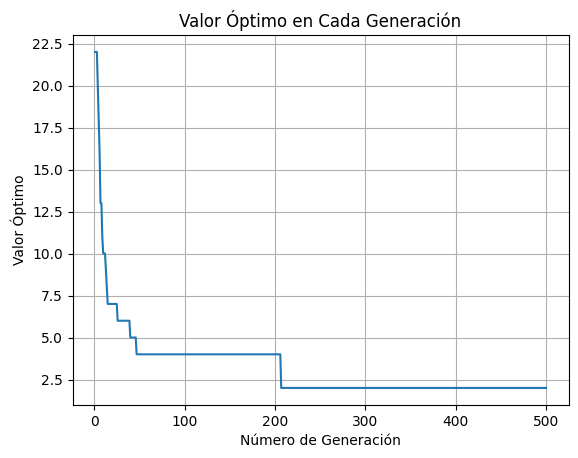

In [ ]:
sudoku = [
    [3, 1, 9, 0, 5, 0, 0, 2, 0],
    [0, 0, 6, 0, 3, 0, 0, 1, 0],
    [4, 5, 2, 0, 0, 0, 6, 8, 3],
    [0, 7, 4, 0, 0, 0, 0, 0, 2],
    [0, 0, 1, 0, 7, 4, 5, 0, 0],
    [8, 0, 5, 1, 0, 9, 7, 6, 0],
    [5, 0, 3, 2, 9, 6, 8, 0, 0],
    [6, 0, 0, 0, 8, 1, 3, 4, 0],
    [0, 9, 8, 0, 4, 0, 0, 0, 6]
]
# sudoku = [
#         [5, 3, 0, 0, 7, 0, 0, 0, 0],
#         [6, 0, 0, 1, 9, 5, 0, 0, 0],
#         [0, 9, 8, 0, 0, 0, 0, 6, 0],
#         [8, 0, 0, 0, 6, 0, 0, 0, 3],
#         [4, 0, 0, 8, 0, 3, 0, 0, 1],
#         [7, 0, 5, 0, 2, 0, 0, 0, 6],
#         [0, 6, 0, 0, 0, 0, 2, 8, 0],
#         [0, 0, 0, 4, 1, 9, 0, 0, 5],
#         [0, 0, 0, 0, 8, 0, 0, 7, 9]
#     ]

tamanoPoblacion = 100
generacionesTotales = 500

cantidadPadres = 100
cantidadSobrevivientes = tamanoPoblacion

crossoverRate = 0.9
mutationRate = 0.4
rowCrossoverRate = 0.1
swapMutationRate = 0.2
reinitializationMutationRate = 0.2

numeroElitismo = 30

funcion = funcionObjetivo

poblacion = inicializarPoblacion(sudoku, tamanoPoblacion)
algoritmoGeneticoPermutaciones(funcion, poblacion, generacionesTotales, torneo, crossoverRate, mutationRate, numeroElitismo)

## Sudoku Mediano

Creando la primera generacion:


Generacion 1

Individuo optimo:
[[3 1 9 8 5 6 7 2 4]
 [7 4 6 2 3 5 9 1 8]
 [4 5 2 9 1 7 6 8 3]
 [5 7 4 6 1 8 3 9 2]
 [8 2 1 3 7 4 5 6 9]
 [8 3 5 1 2 9 7 6 4]
 [5 1 3 2 9 6 8 4 7]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 3 4 7 2 5 6]]

	Su aptitud es de 25

Generacion 2

Individuo optimo:
[[3 1 9 4 5 8 6 2 7]
 [7 4 6 2 3 5 9 1 8]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 1 6 5 3 2]
 [2 6 1 3 7 4 5 8 9]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 5 9 2 8 1 3 4 7]
 [1 9 8 7 4 3 2 5 6]]

	Su aptitud es de 21

Generacion 3

Individuo optimo:
[[3 1 9 4 5 6 8 2 7]
 [7 2 6 4 3 8 9 1 5]
 [4 5 2 7 1 9 6 8 3]
 [9 7 4 8 6 3 5 1 2]
 [2 6 1 3 7 4 5 8 9]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 2 4 7 5 3 6]]

	Su aptitud es de 18

Generacion 4

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 2 6 4 3 8 9 1 5]
 [4 5 2 7 1 9 6 8 3]
 [5 7 4 8 6 3 1 9 2]
 [9 6 1 8 7 4 5 3 2]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 3 4 7 2 5 6]]

	Su aptit

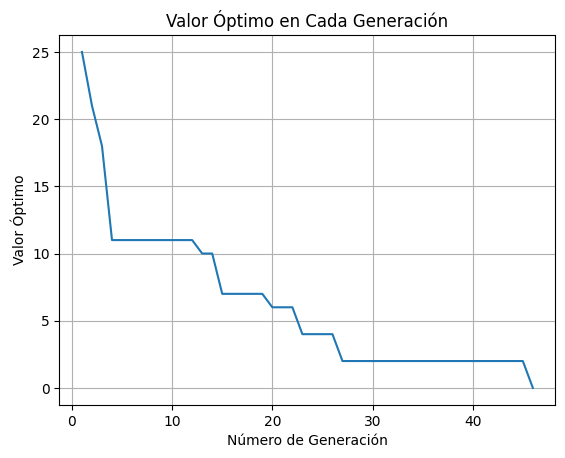

In [ ]:
sudoku = [
    [3, 1, 9, 0, 5, 0, 0, 2, 0],
    [0, 0, 6, 0, 3, 0, 0, 1, 0],
    [4, 5, 2, 0, 1, 0, 6, 8, 3],
    [0, 7, 4, 0, 0, 0, 0, 0, 2],
    [0, 0, 1, 0, 7, 4, 5, 0, 0],
    [8, 0, 5, 1, 2, 9, 7, 6, 0],
    [5, 0, 3, 2, 9, 6, 8, 0, 0],
    [6, 0, 0, 0, 8, 1, 3, 4, 0],
    [1, 9, 8, 0, 4, 0, 0, 0, 6]
]

tamanoPoblacion = 100
generacionesTotales = 500

cantidadPadres = 100
cantidadSobrevivientes = tamanoPoblacion

crossoverRate = 0.9
mutationRate = 0.4
rowCrossoverRate = 0.1
swapMutationRate = 0.2
reinitializationMutationRate = 0.2

numeroElitismo = 30

funcion = funcionObjetivo

poblacion = inicializarPoblacion(sudoku, tamanoPoblacion)
algoritmoGeneticoPermutaciones(funcion, poblacion, generacionesTotales, torneo, crossoverRate, mutationRate, numeroElitismo)

## Sudoku Facil

Creando la primera generacion:


Generacion 1

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 7 1 9 6 8 3]
 [5 7 4 9 6 8 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 7 3 2 9 6 8 4 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 5 4 3 2 7 6]]

	Su aptitud es de 11

Generacion 2

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 7 1 9 6 8 3]
 [5 7 4 9 6 8 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 7 3 2 9 6 8 4 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 5 4 3 2 7 6]]

	Su aptitud es de 11

Generacion 3

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 5 3 2 4 1 9]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 9 8 1 3 4 5]
 [1 9 8 5 4 3 7 2 6]]

	Su aptitud es de 9

Generacion 4

Individuo optimo:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 5 3 2 4 1 9]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 9 8 1 3 4 5]
 [1 9 8 5 4 3 7 2 6]]

	Su aptitu

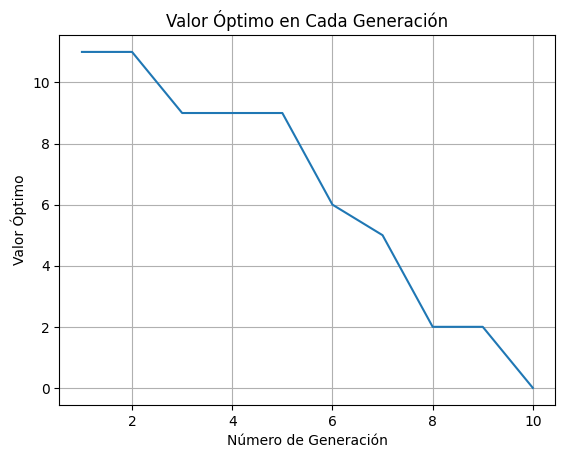

In [ ]:
sudoku = [
    [3, 1, 9, 0, 5, 0, 4, 2, 0],
    [7, 0, 6, 0, 3, 2, 0, 1, 0],
    [4, 5, 2, 0, 1, 0, 6, 8, 3],
    [0, 7, 4, 0, 0, 0, 1, 3, 2],
    [2, 0, 1, 0, 7, 4, 5, 0, 0],
    [8, 0, 5, 1, 2, 9, 7, 6, 4],
    [5, 0, 3, 2, 9, 6, 8, 0, 1],
    [6, 2, 0, 0, 8, 1, 3, 4, 0],
    [1, 9, 8, 0, 4, 3, 0, 0, 6]
]

tamanoPoblacion = 100
generacionesTotales = 500

cantidadPadres = 100
cantidadSobrevivientes = tamanoPoblacion

crossoverRate = 0.9
mutationRate = 0.4
rowCrossoverRate = 0.1
swapMutationRate = 0.2
reinitializationMutationRate = 0.2

numeroElitismo = 30

funcion = funcionObjetivo

poblacion = inicializarPoblacion(sudoku, tamanoPoblacion)
algoritmoGeneticoPermutaciones(funcion, poblacion, generacionesTotales, torneo, crossoverRate, mutationRate, numeroElitismo)

## Pruebas

Creando la primera generacion:

Se ha encontrado la solucion en la generacion 29
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


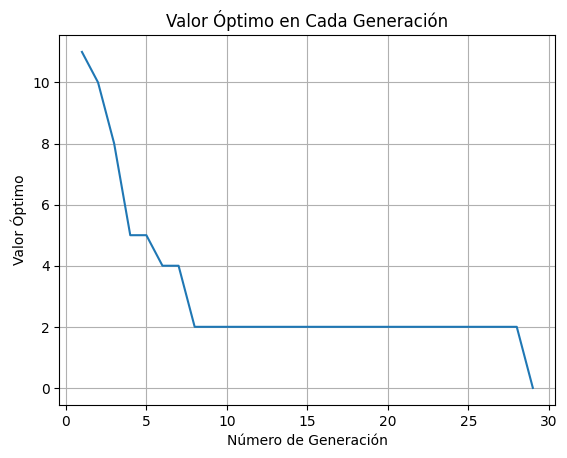

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


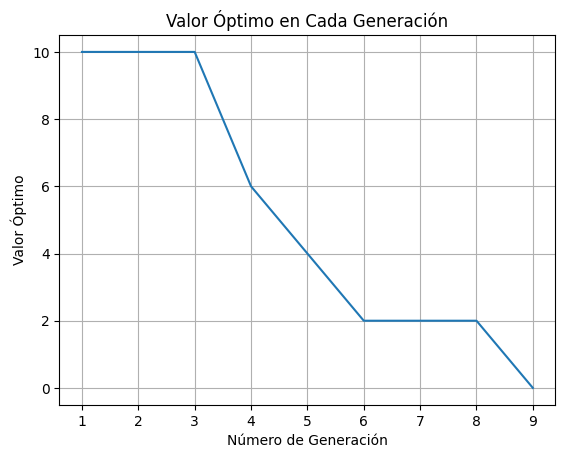

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 17
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


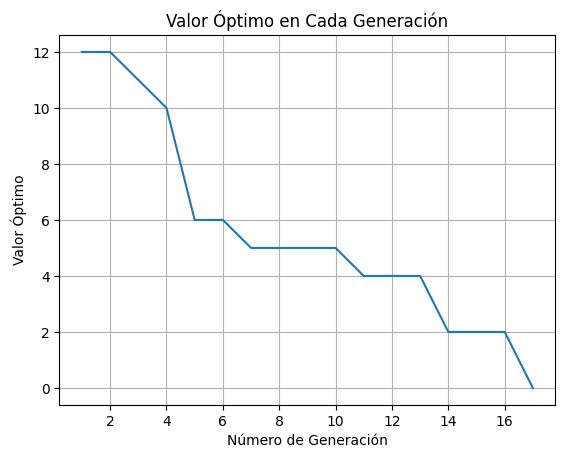

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


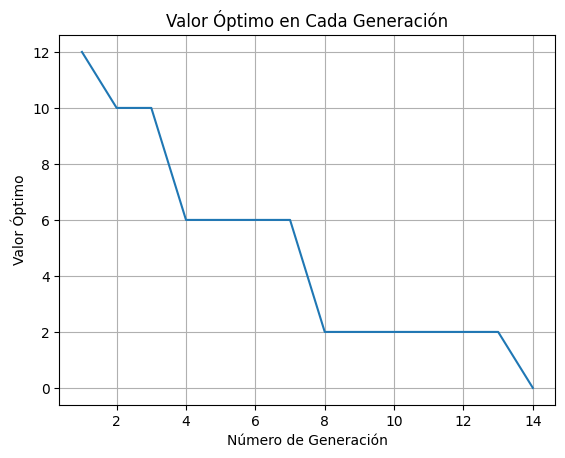

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


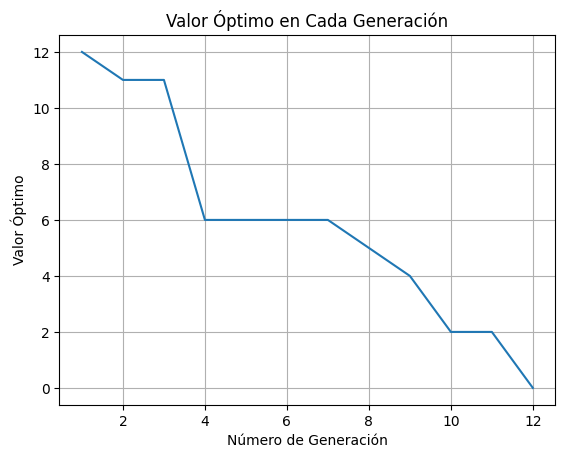

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 16
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


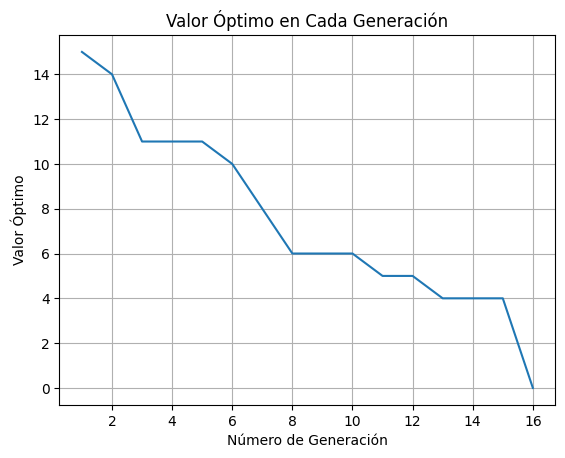

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


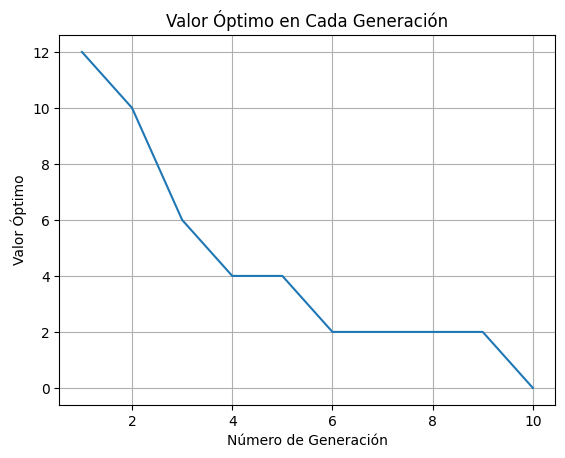

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


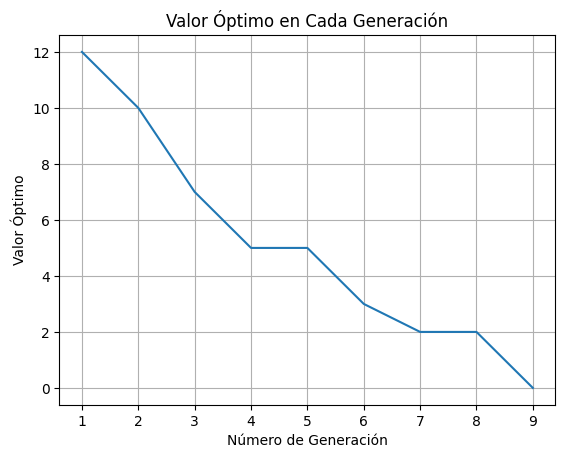

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


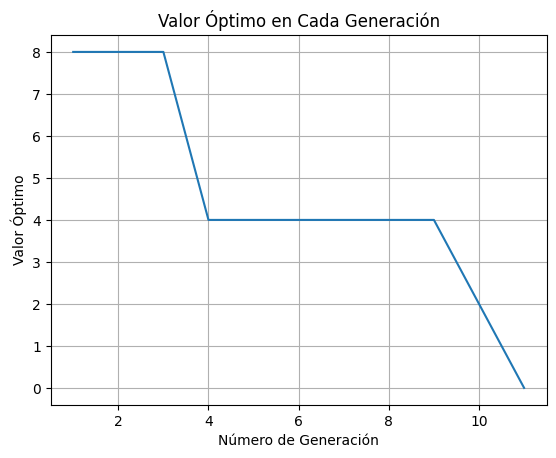

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


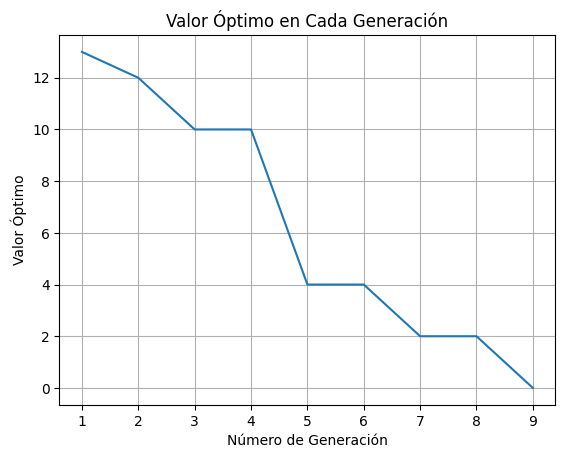

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 13
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


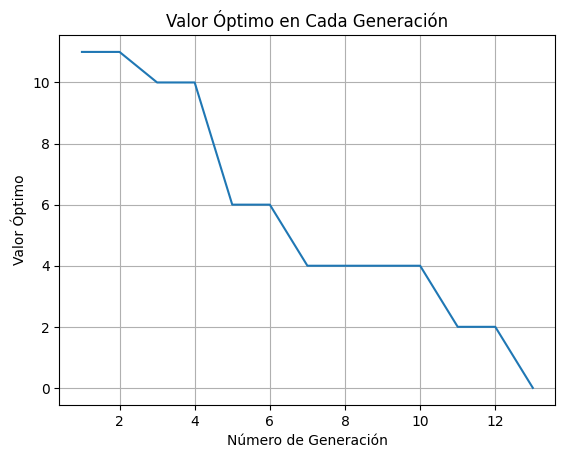

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 17
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


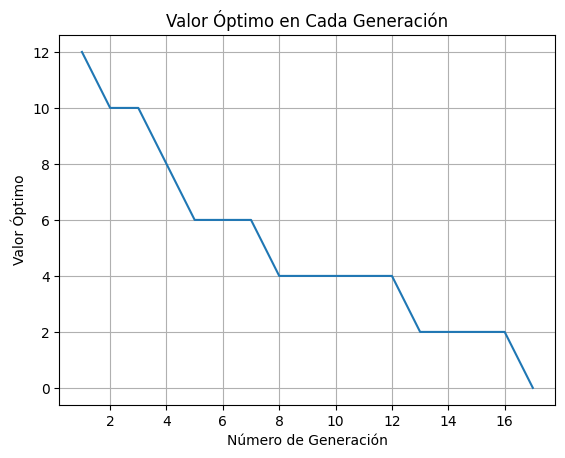

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


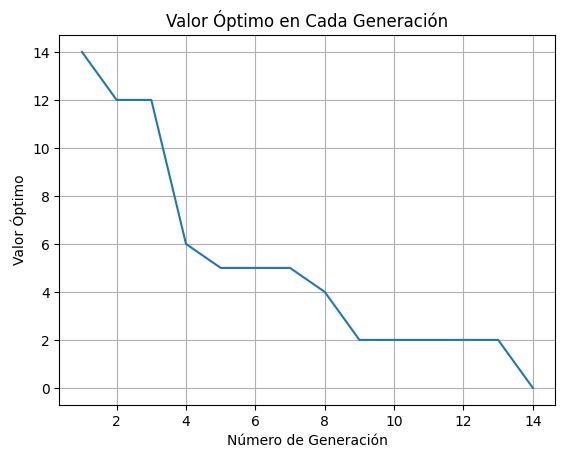

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


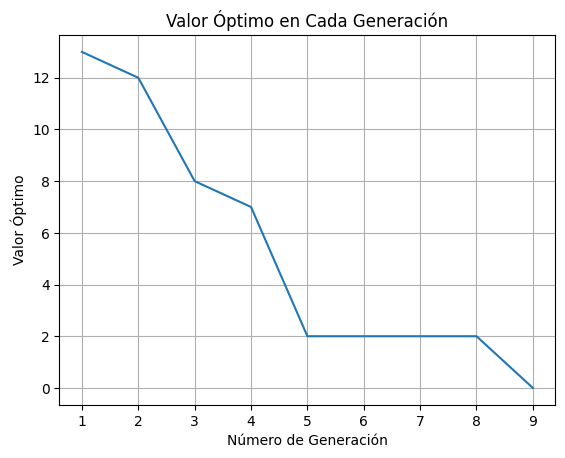

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


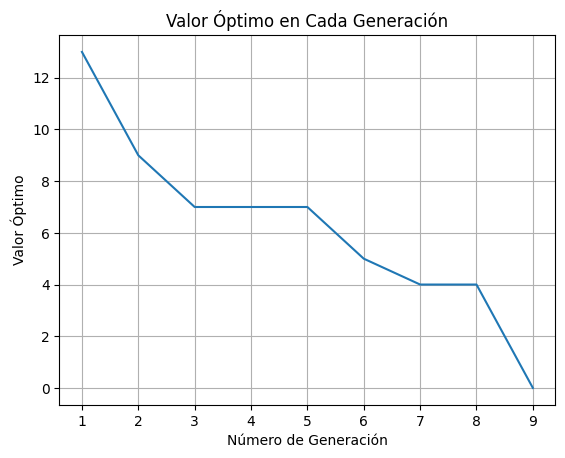

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 16
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


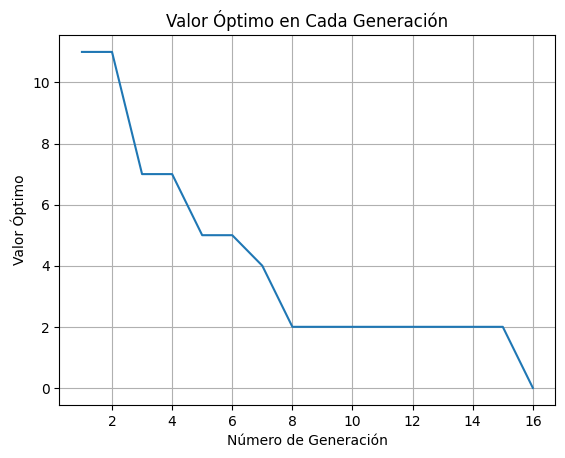

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 24
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


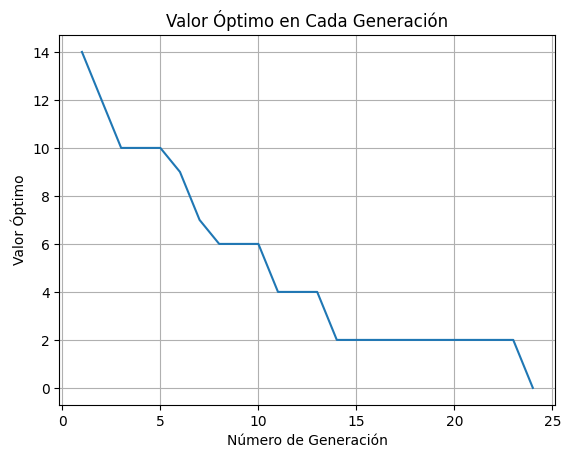

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


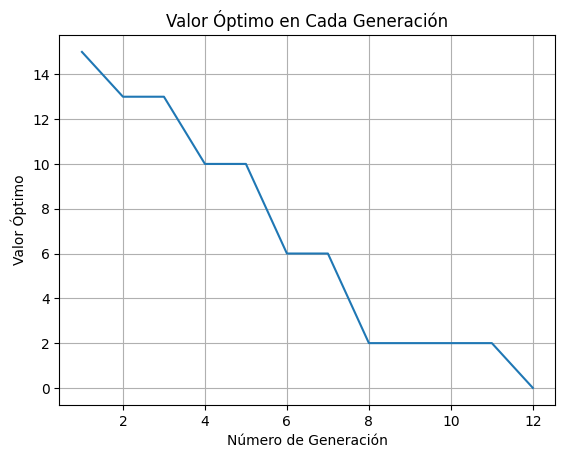

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


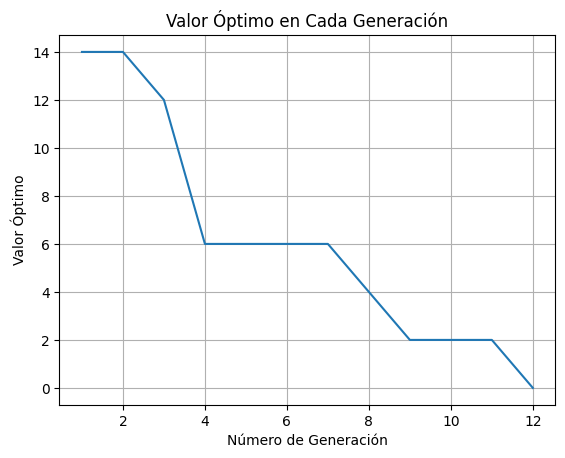

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


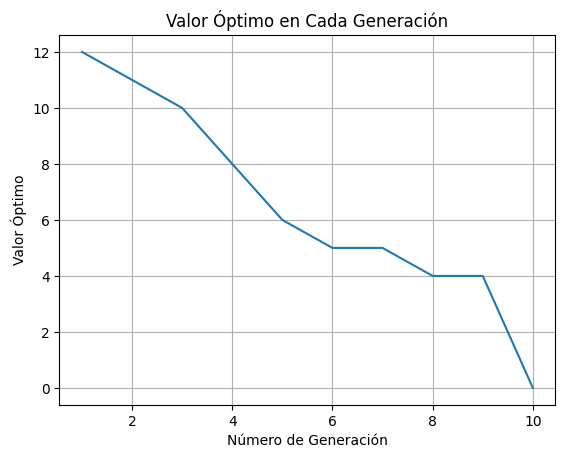

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 25
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


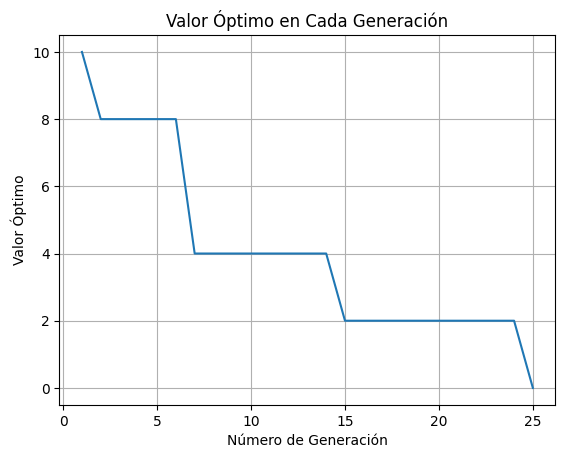

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 6
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


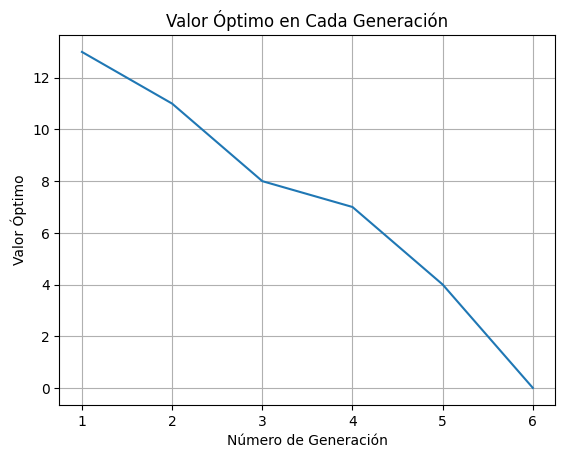

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


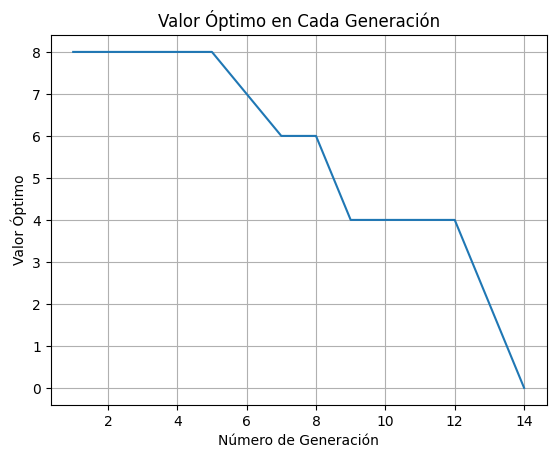

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


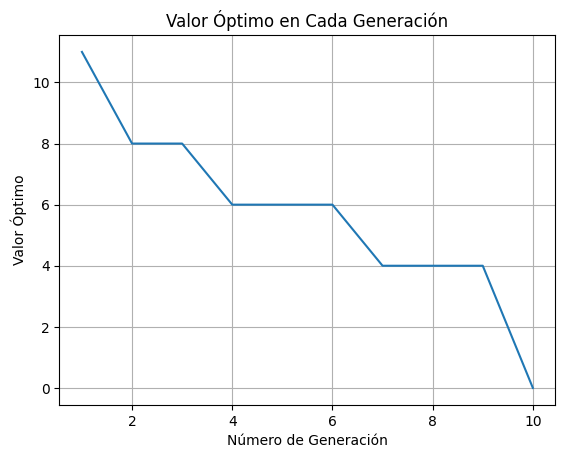

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


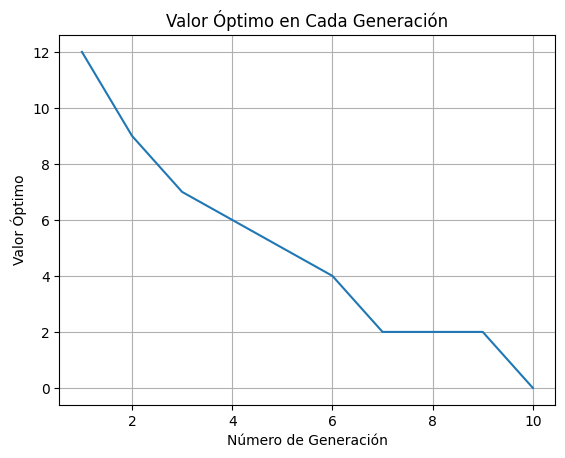

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


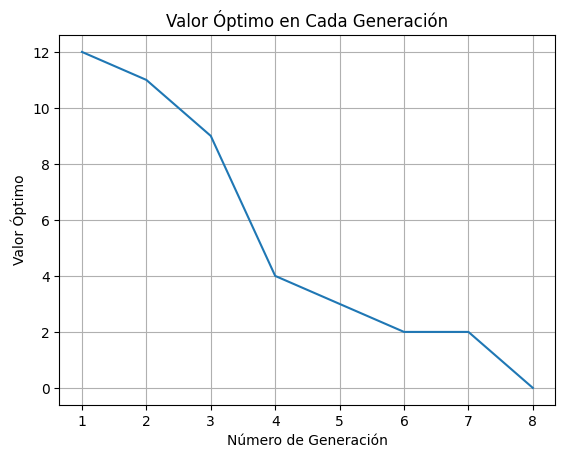

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


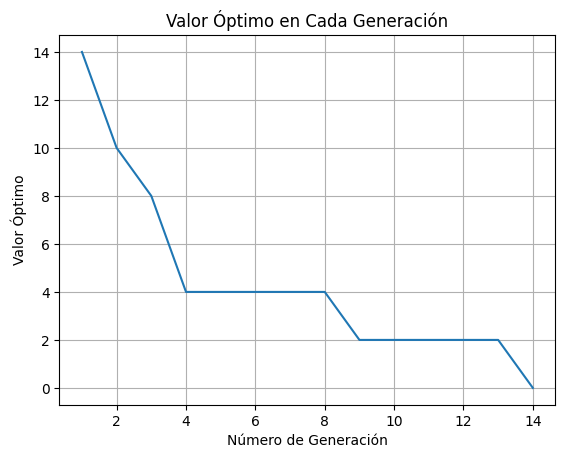

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 6
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


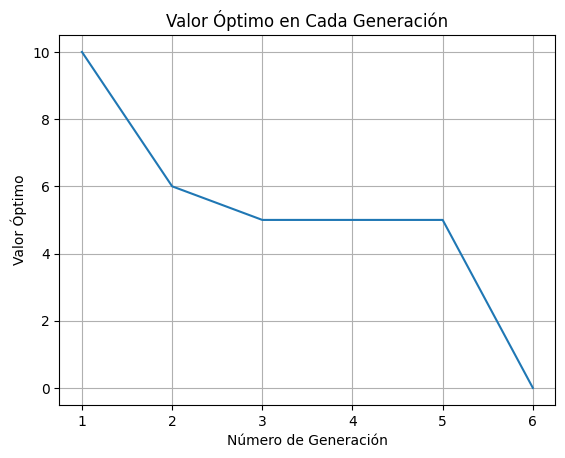

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


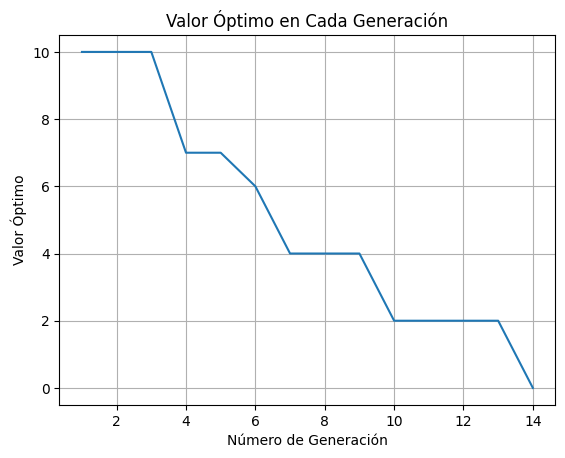

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 13
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


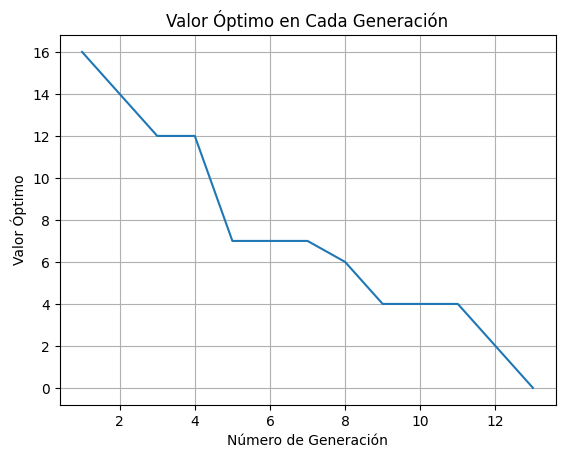

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


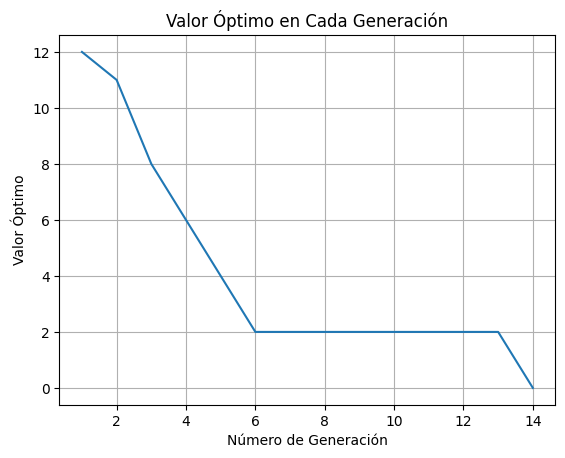

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


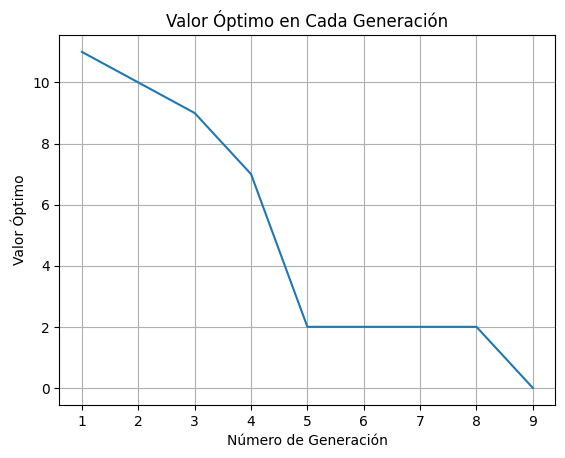

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


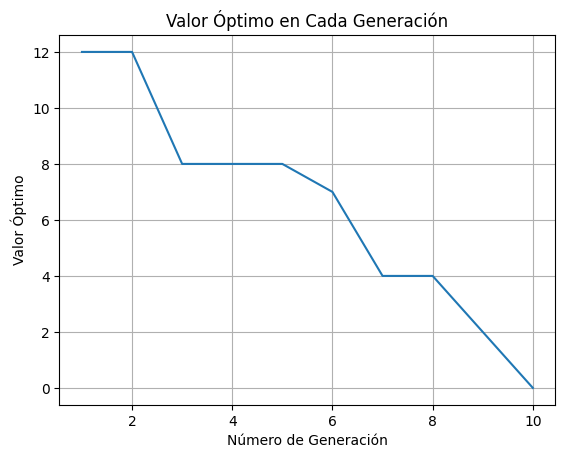

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


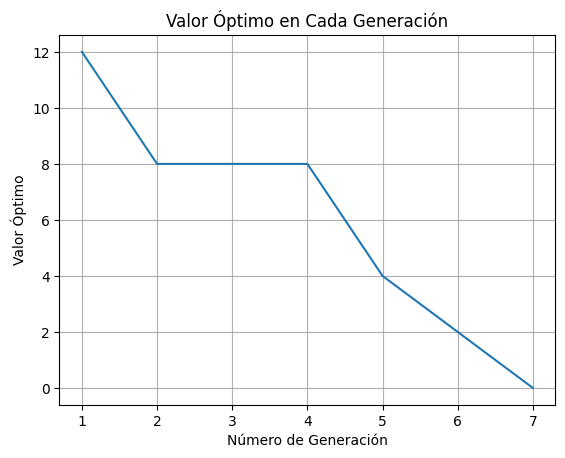

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


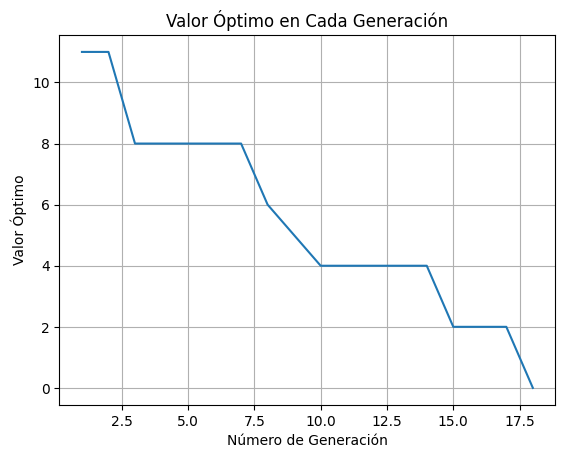

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 15
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


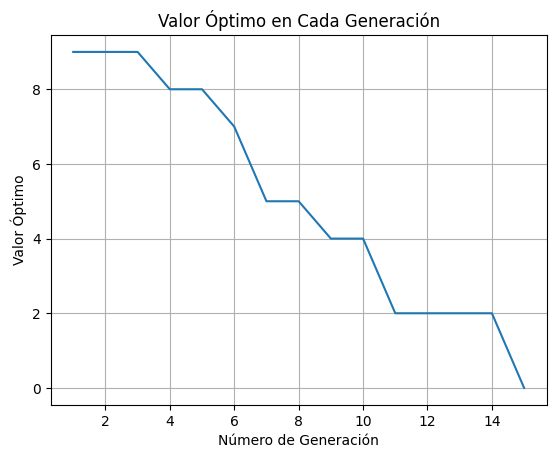

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 16
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


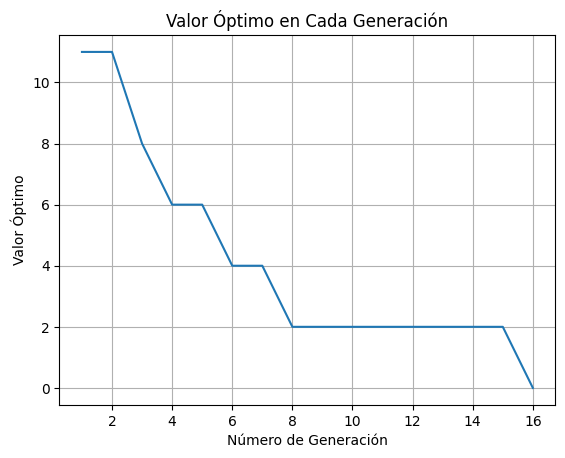

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


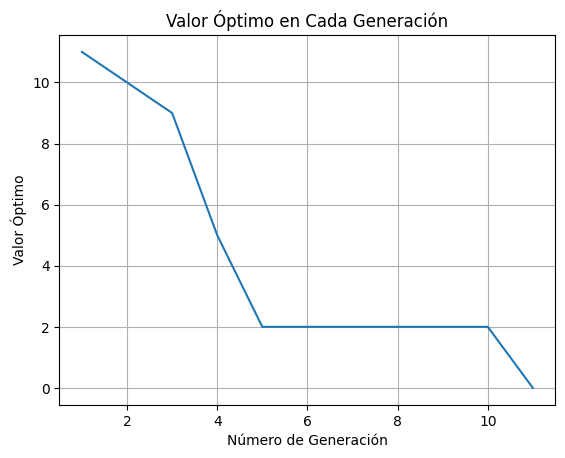

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


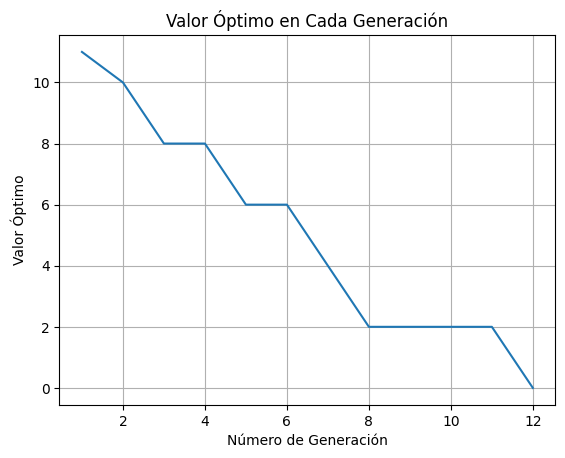

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


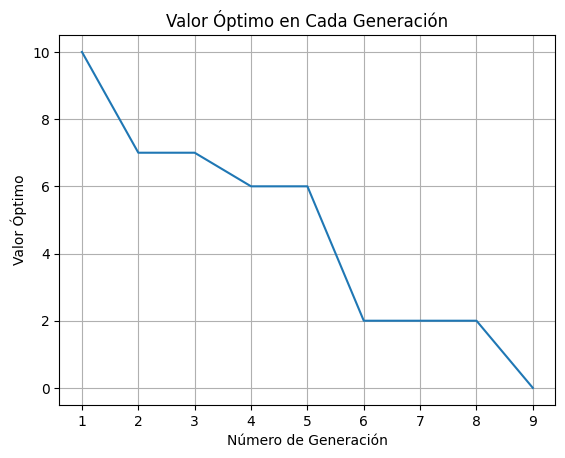

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


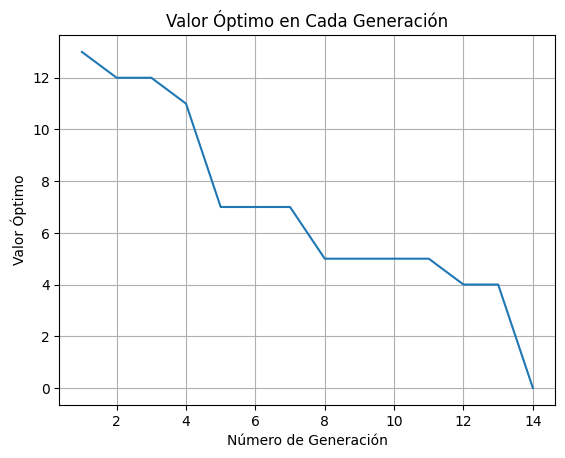

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 6
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


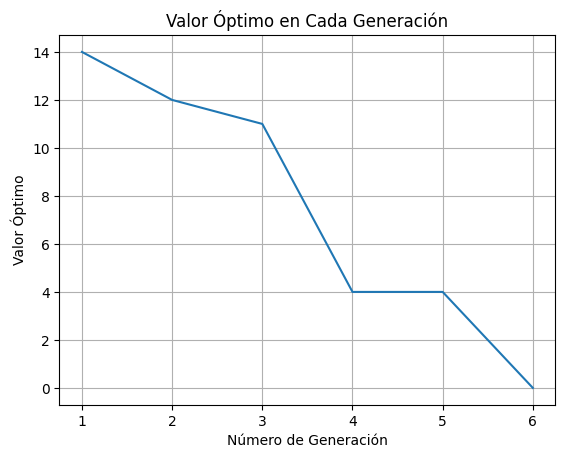

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


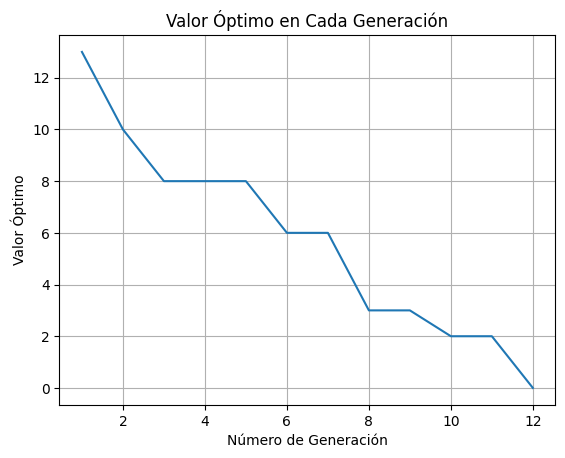

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


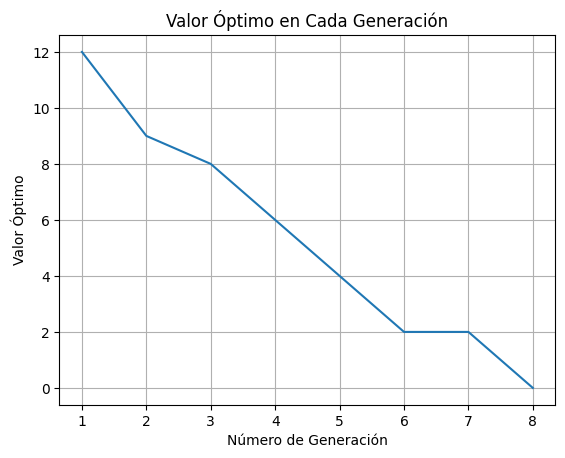

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


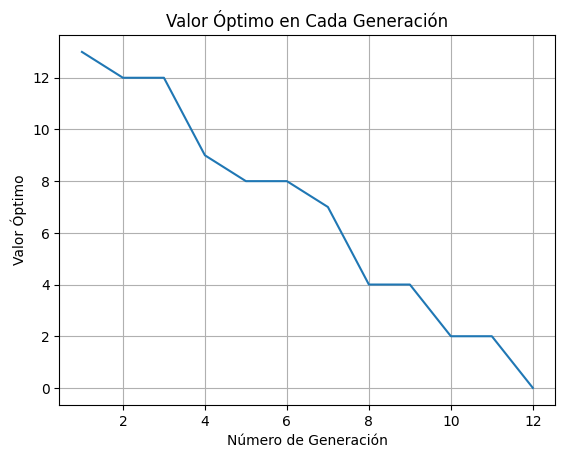

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


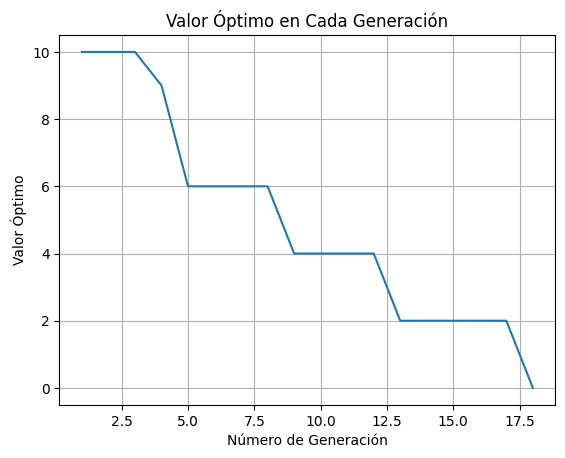

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 15
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


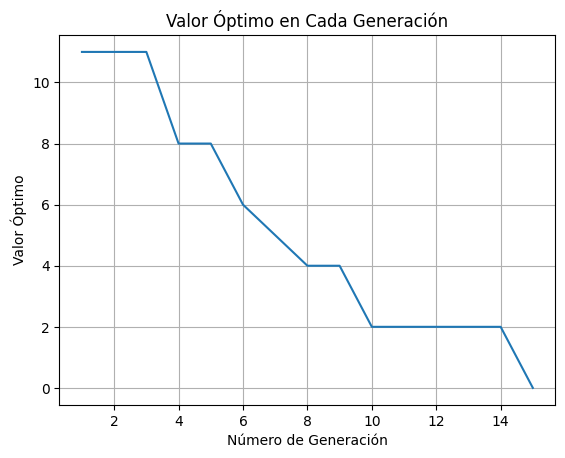

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


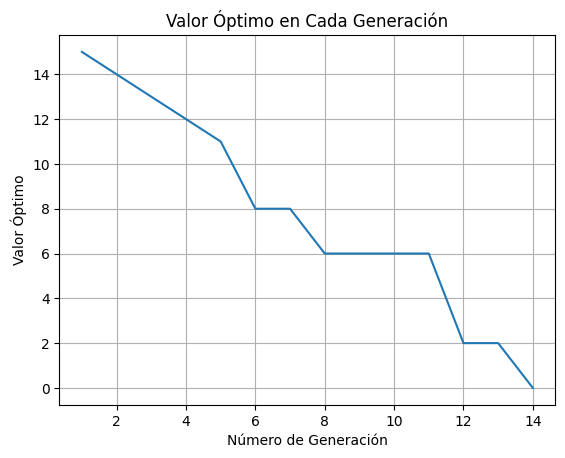

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


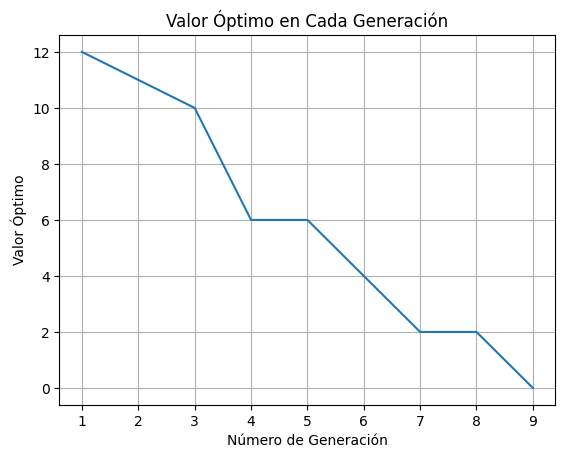

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


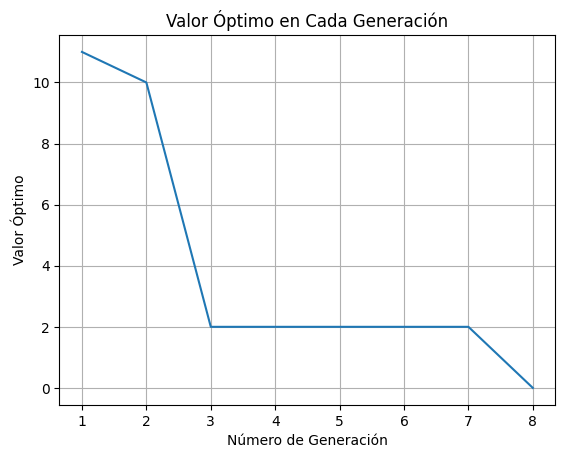

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


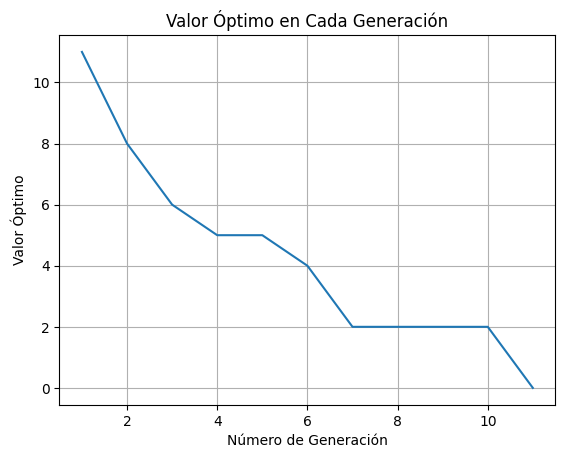

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 22
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


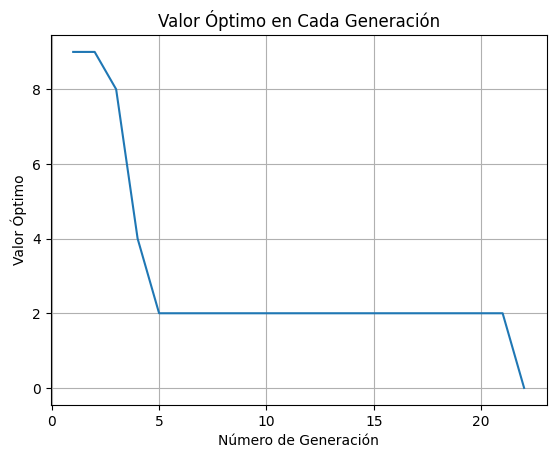

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 16
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


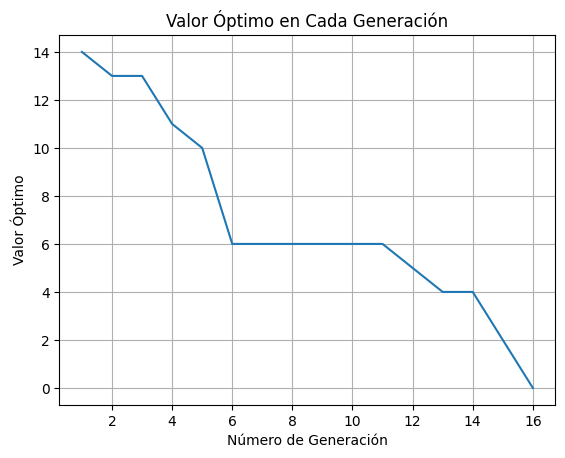

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


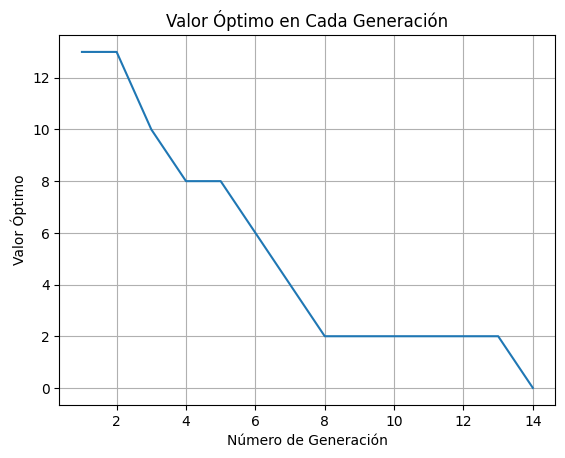

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


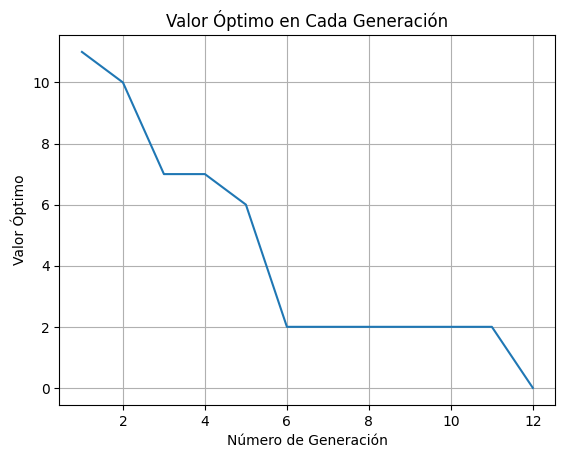

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


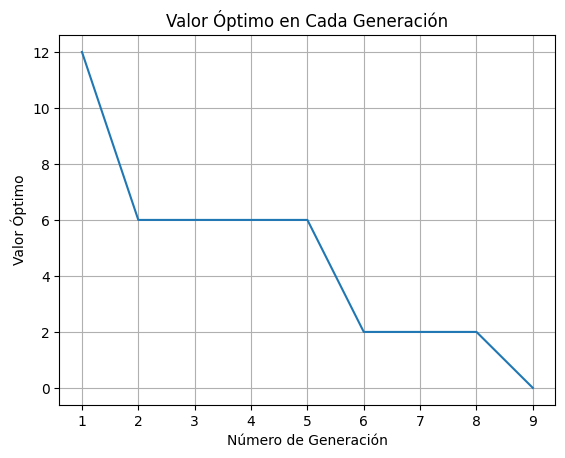

Se uso la configuración: 

crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


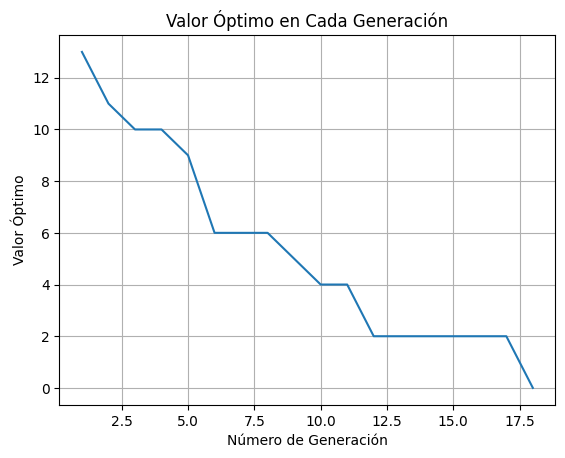

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


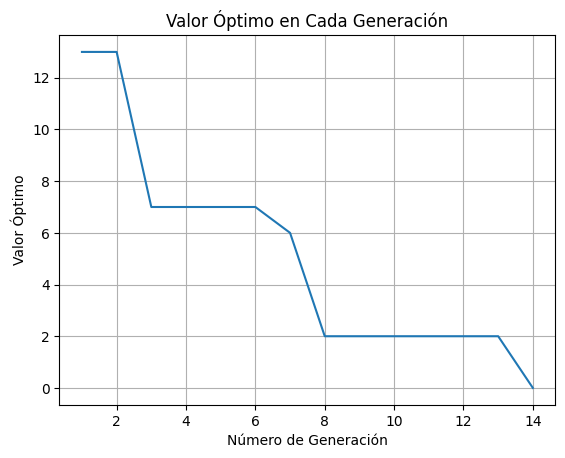

Se uso la configuración: 

crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


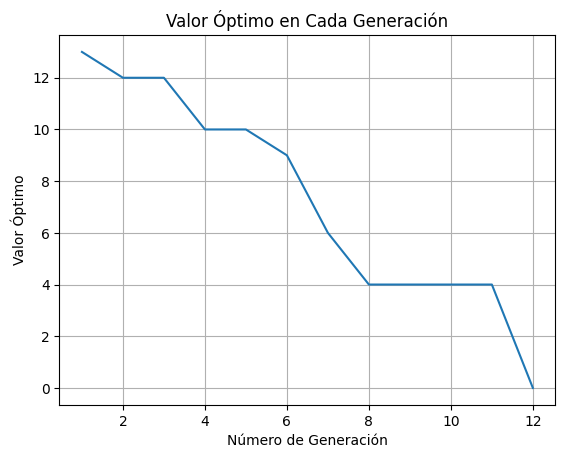

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 21
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


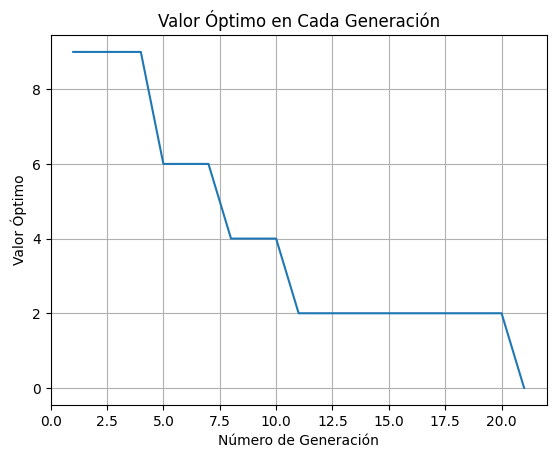

Se uso la configuración: 

crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500


In [ ]:
semillas=[1,2,3,4,5,6,7,8,9,10]

sudoku = [
    [3, 1, 9, 0, 5, 0, 4, 2, 0],
    [7, 0, 6, 0, 3, 2, 0, 1, 0],
    [4, 5, 2, 0, 1, 0, 6, 8, 3],
    [0, 7, 4, 0, 0, 0, 1, 3, 2],
    [2, 0, 1, 0, 7, 4, 5, 0, 0],
    [8, 0, 5, 1, 2, 9, 7, 6, 4],
    [5, 0, 3, 2, 9, 6, 8, 0, 1],
    [6, 2, 0, 0, 8, 1, 3, 4, 0],
    [1, 9, 8, 0, 4, 3, 0, 0, 6]
]


for semilla in semillas:
  tamanoPoblacion = 100
  generacionesTotales = 500

  cantidadPadres = 100
  cantidadSobrevivientes = tamanoPoblacion

  crossoverRate = [0.9,0.7,0.5]
  mutationRate = [0.4,0.2]
  for crossover in crossoverRate:
    for mutation in mutationRate:
      rowCrossoverRate = 0.1
      swapMutationRate = 0.2
      reinitializationMutationRate = 0.2

      numeroElitismo = 30

      funcion = funcionObjetivo

      poblacion = inicializarPoblacion(sudoku, tamanoPoblacion)
      algoritmoGeneticoPermutaciones(funcion, poblacion, generacionesTotales, torneo, crossover, mutation, numeroElitismo)
      print(f'Se uso la configuración: \n')
      print(f'Se uso la semilla: ', semilla )
      print(f'crossoverRate: {crossover}')
      print(f'mutationRate: {mutation}')
      print(f'rowCrossoverRate: {rowCrossoverRate}')
      print(f'swapMutationRate: {swapMutationRate}')
      print(f'reinitializationMutationRate: {reinitializationMutationRate}')
      print(f'numeroElitismo: {numeroElitismo}')
      print(f'tamanoPoblacion: {tamanoPoblacion}')
      print(f'generacionesTotales: {generacionesTotales}')

Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


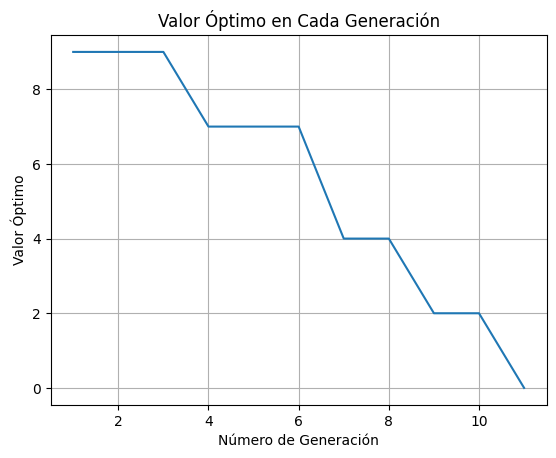

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


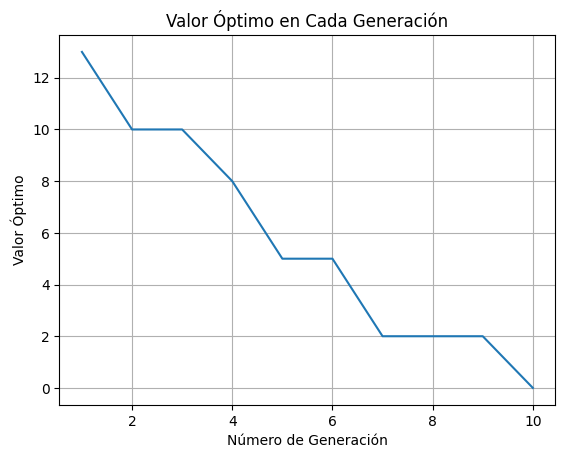

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


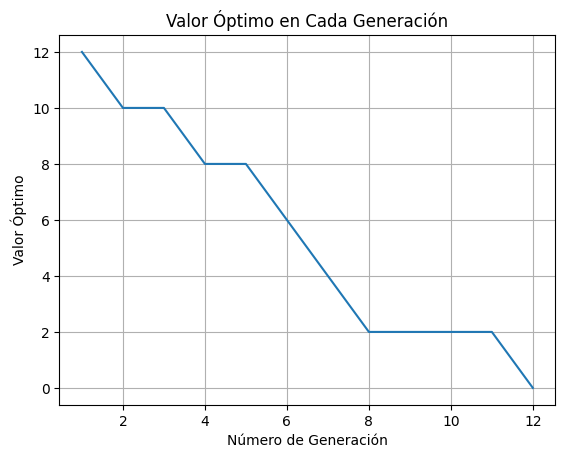

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


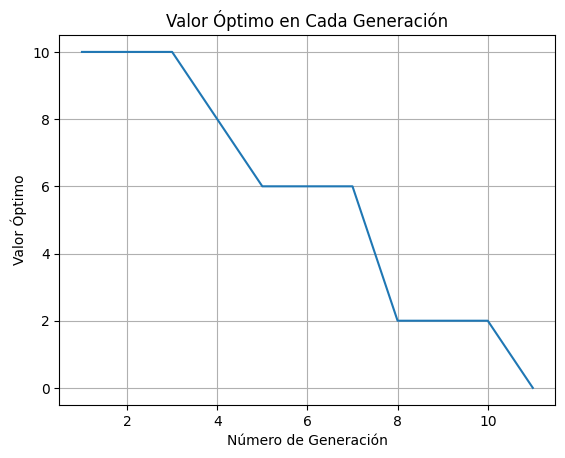

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


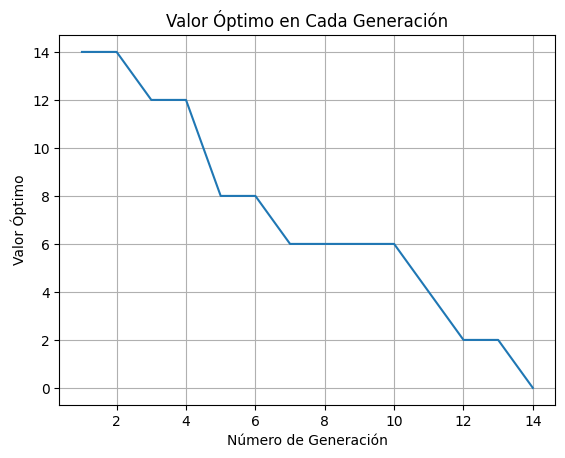

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 21
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


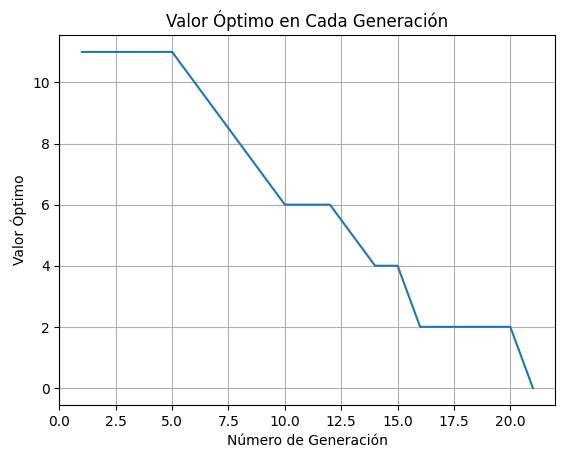

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


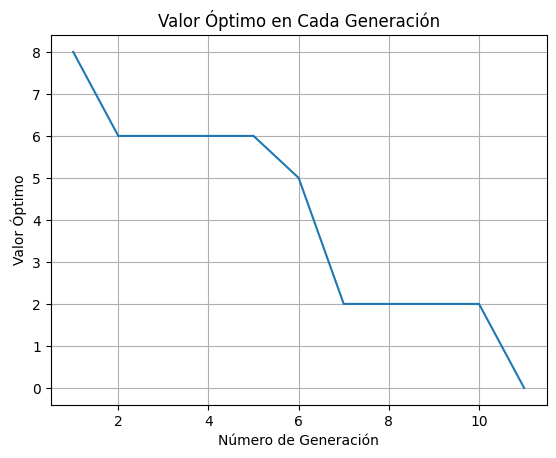

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


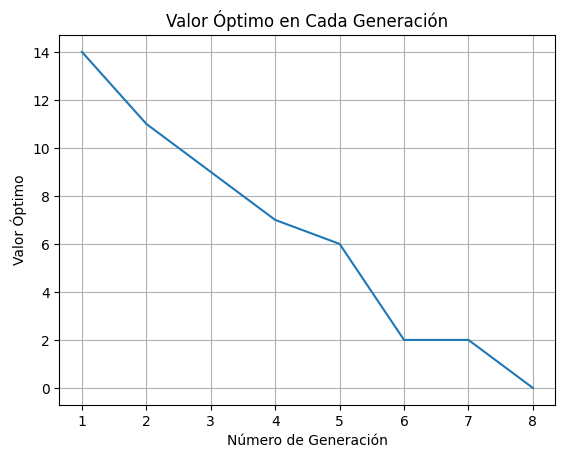

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


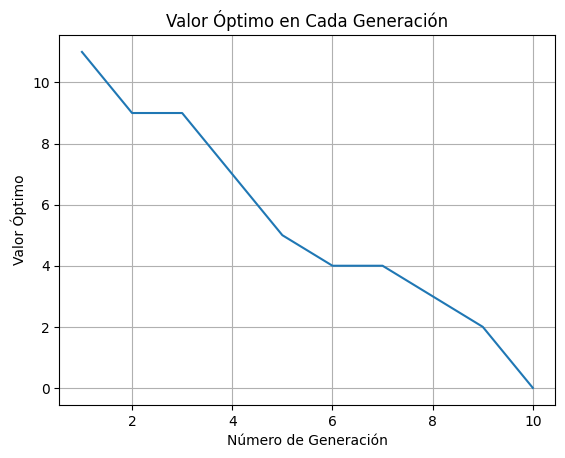

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


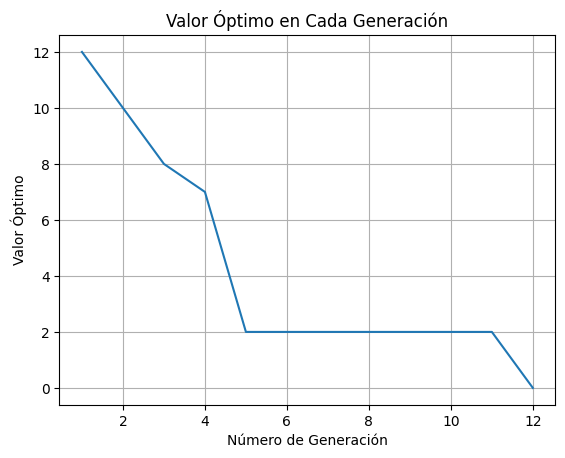

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 15
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


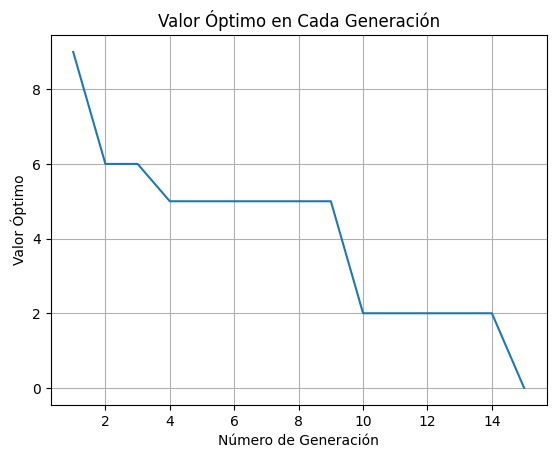

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 26
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


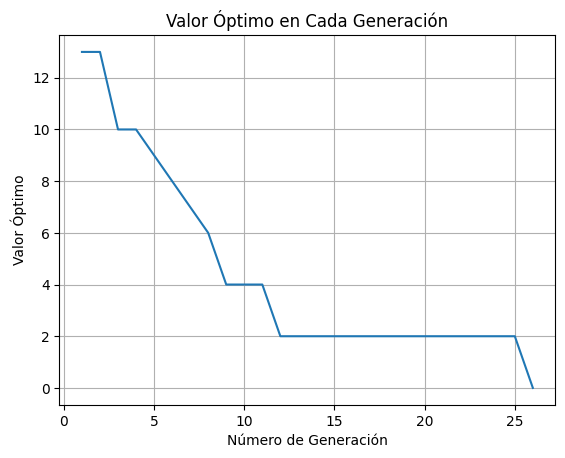

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 6
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


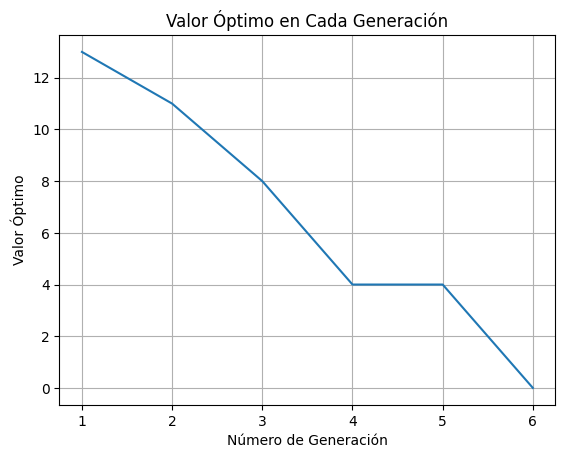

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


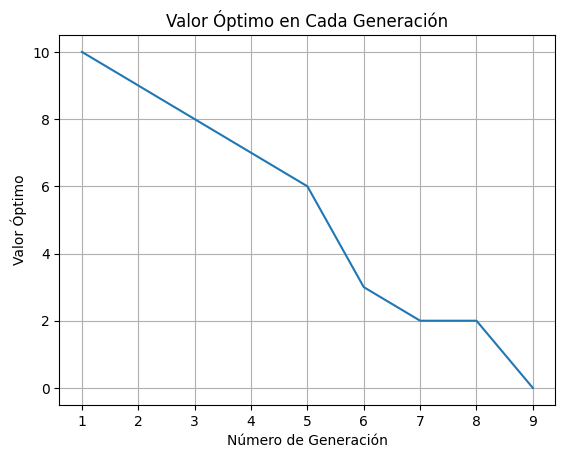

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


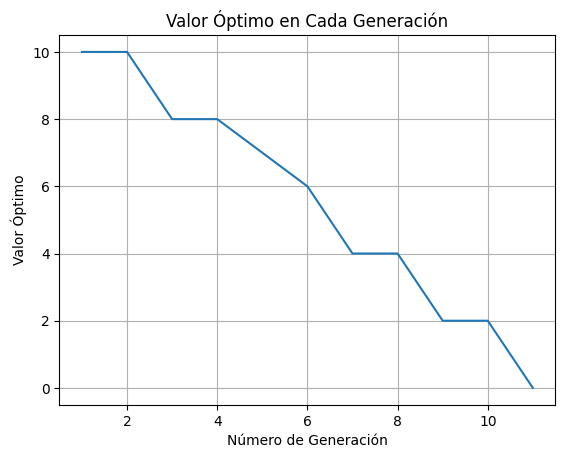

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


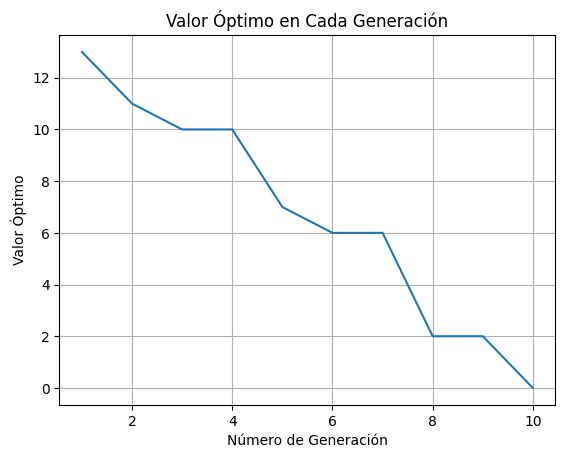

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 20
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


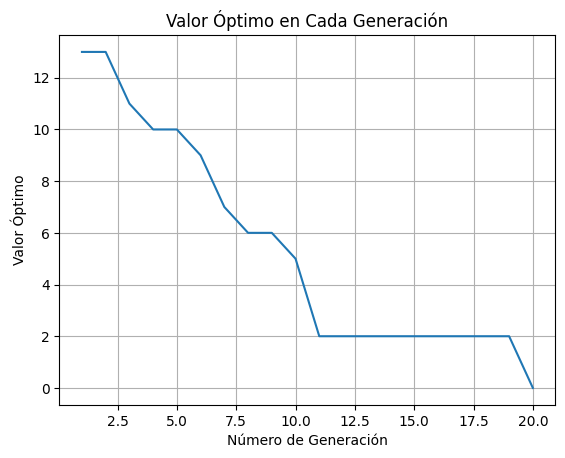

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 16
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


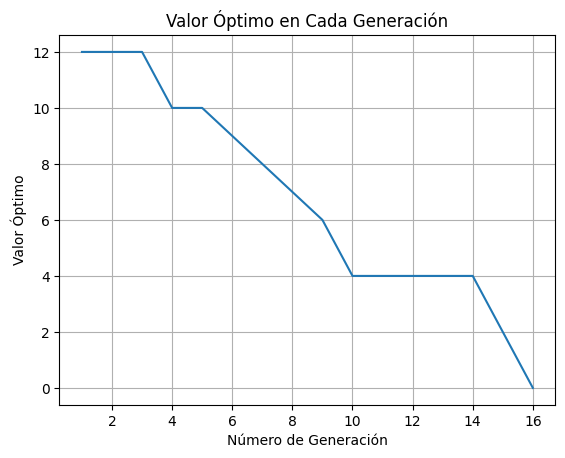

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


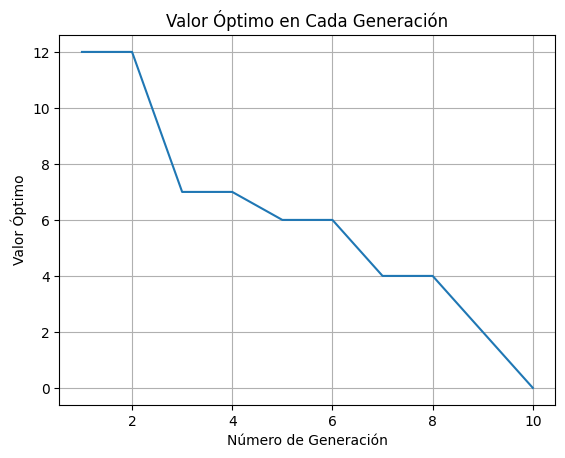

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


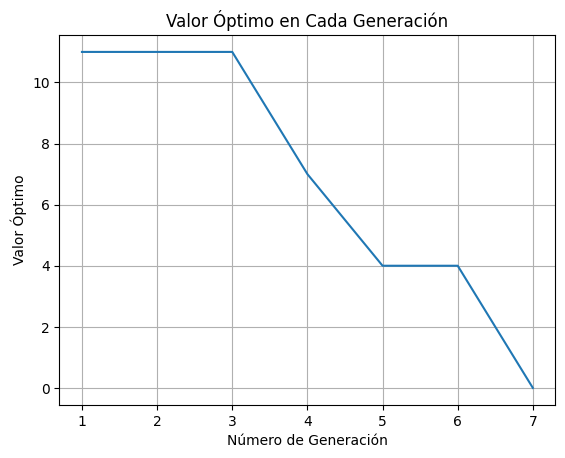

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


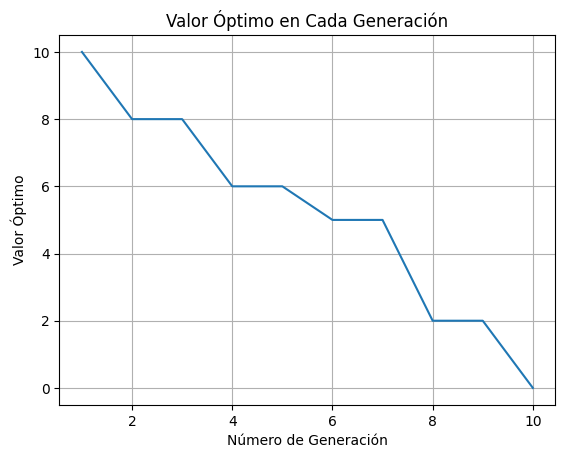

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


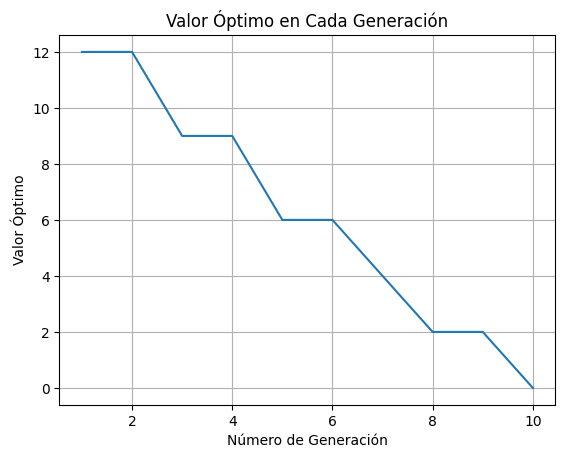

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 28
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


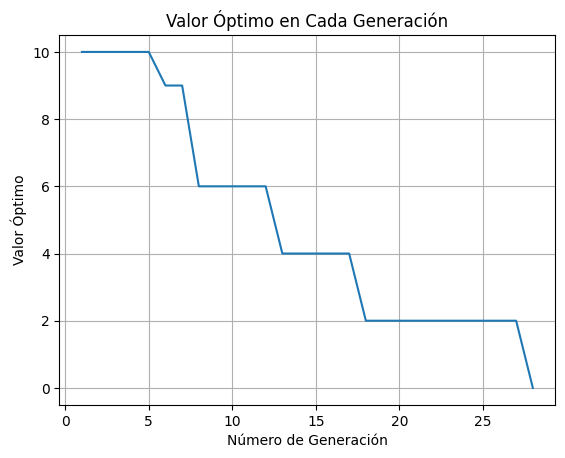

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 15
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


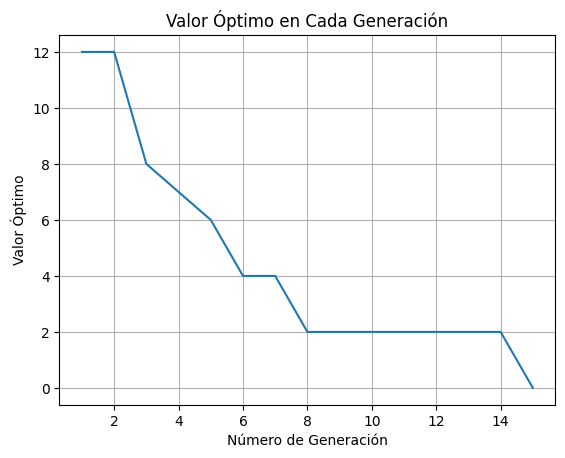

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


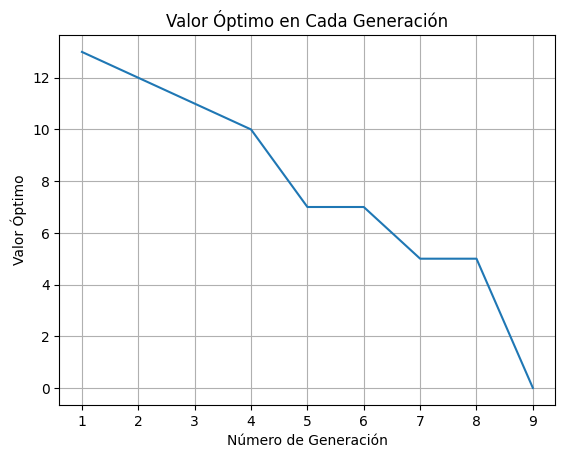

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


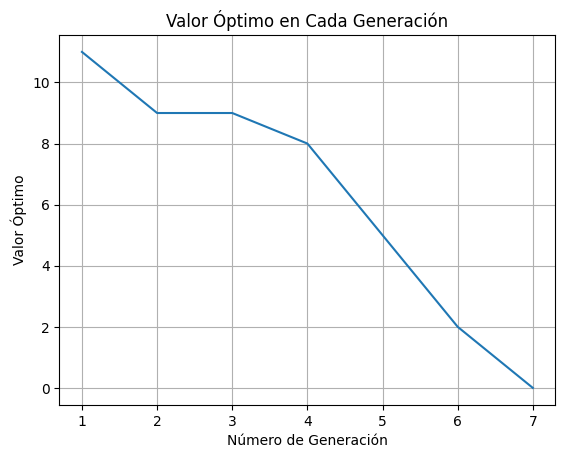

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 21
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


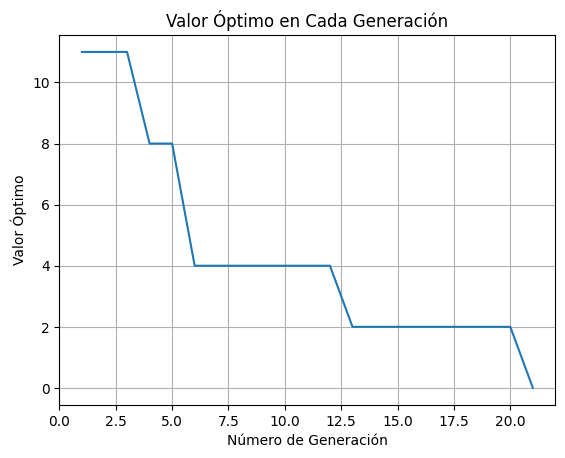

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 15
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


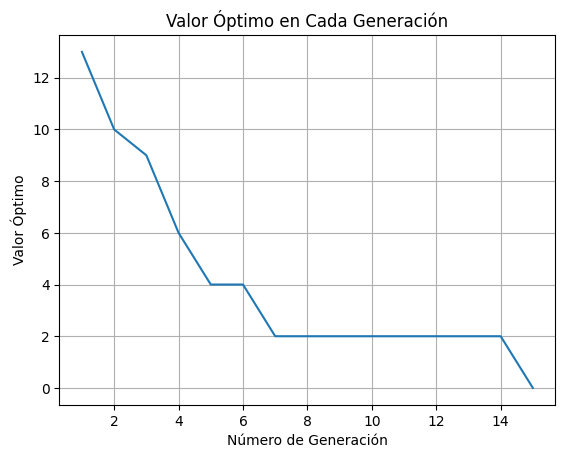

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 16
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


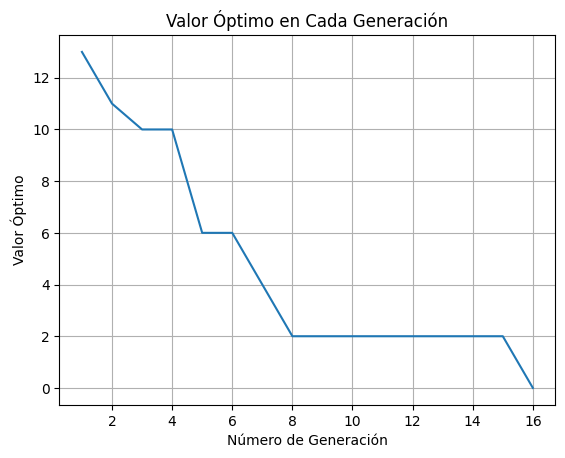

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


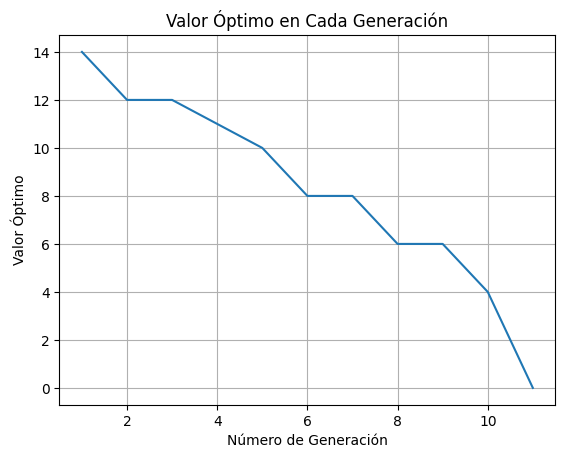

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


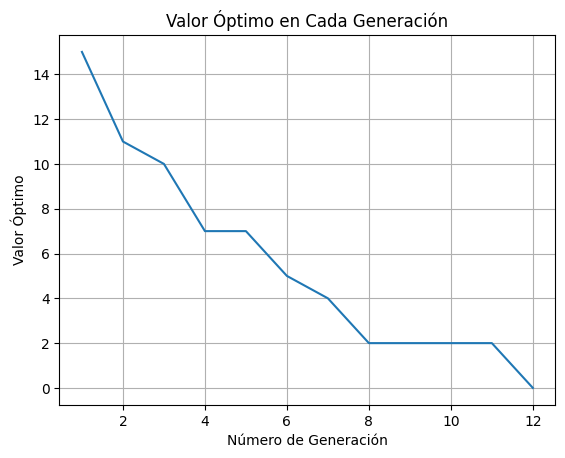

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


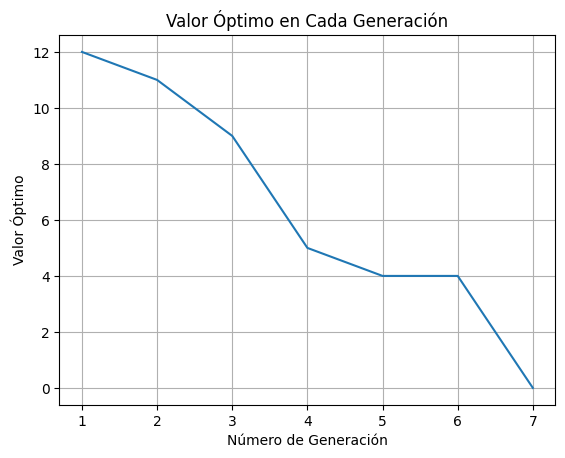

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


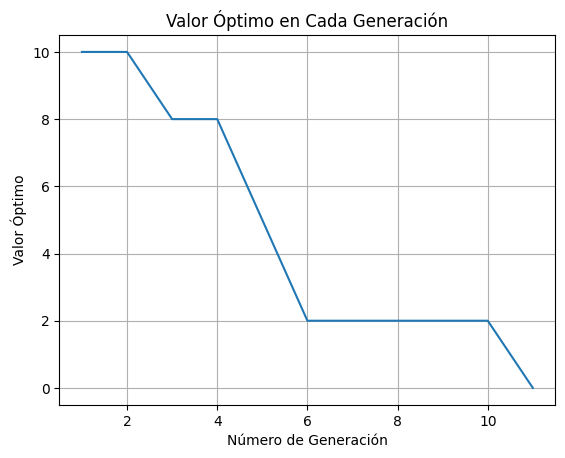

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


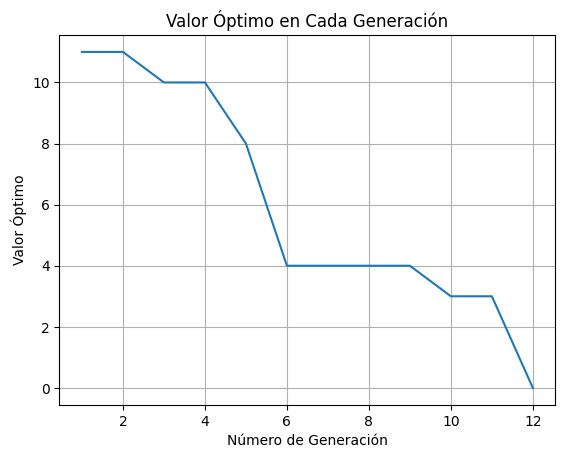

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


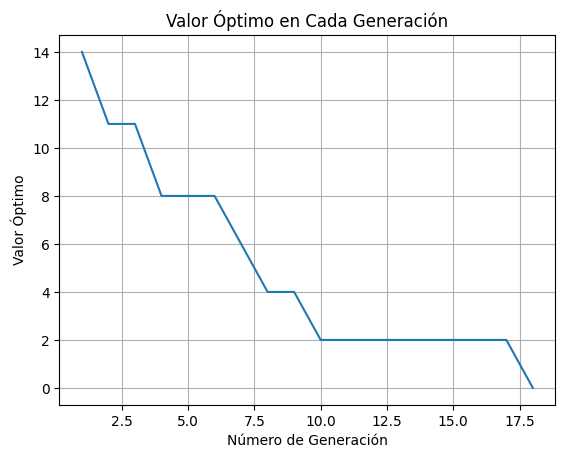

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 13
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


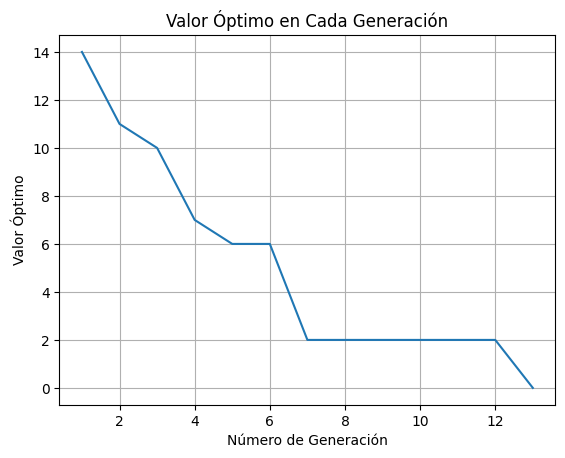

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


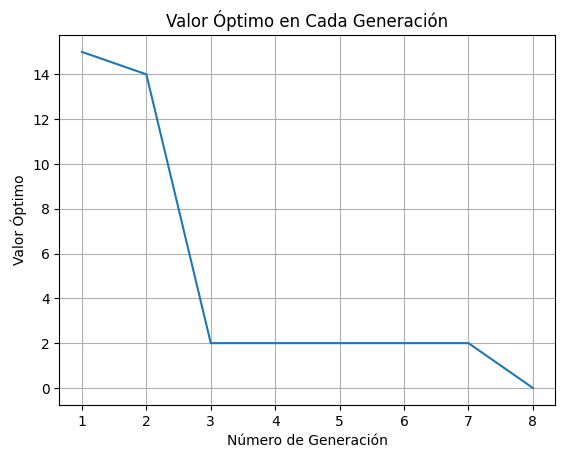

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


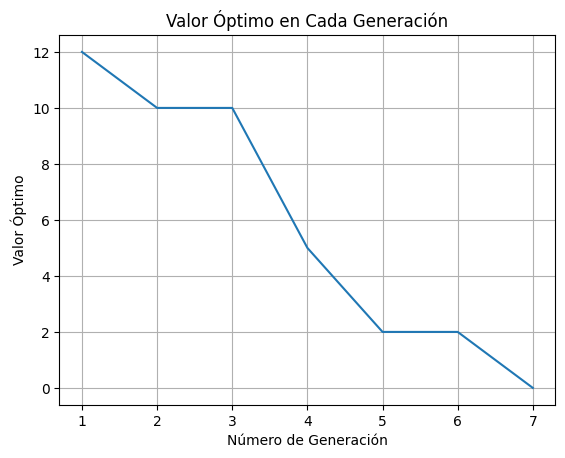

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


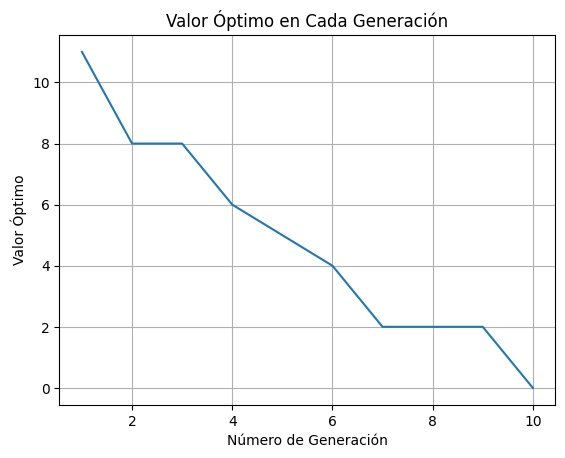

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


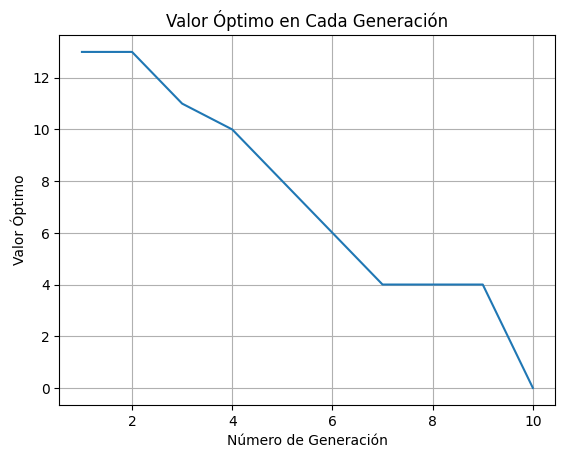

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 19
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


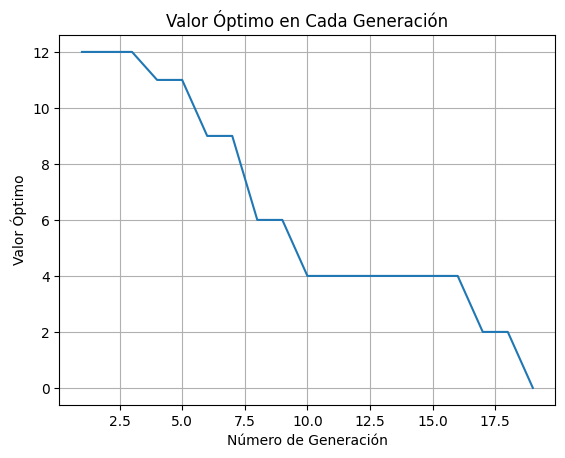

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 23
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


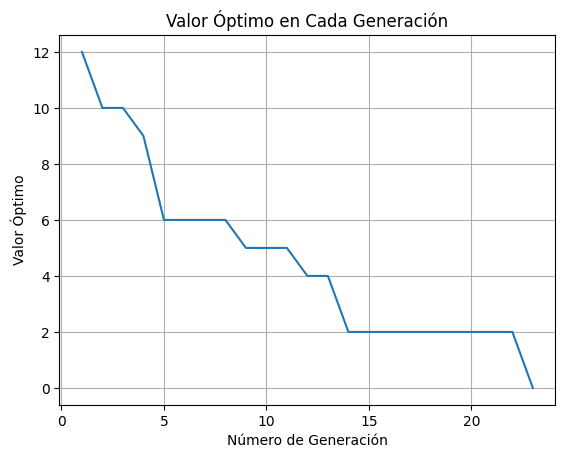

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


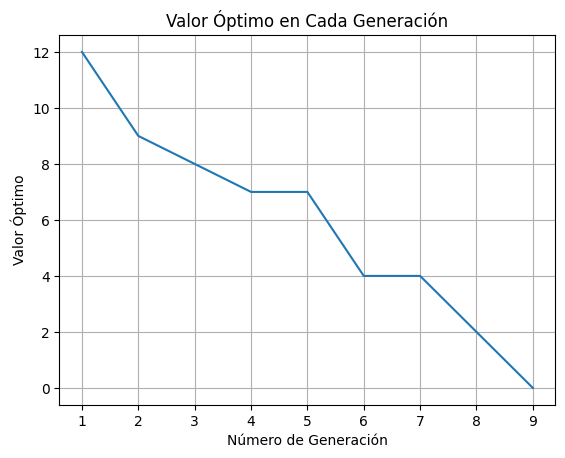

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


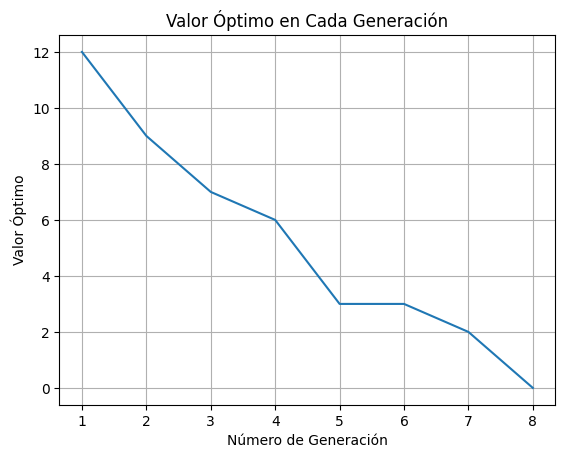

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


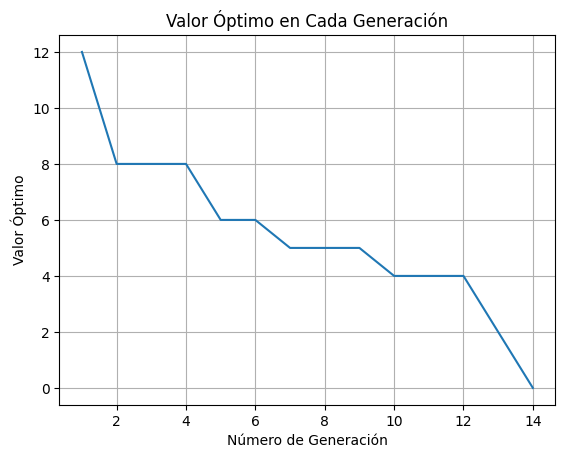

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


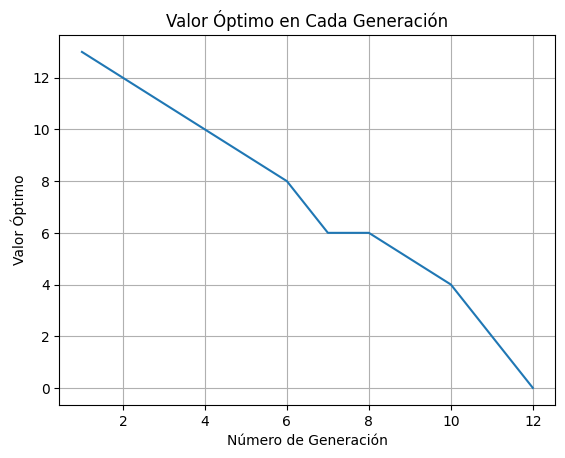

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


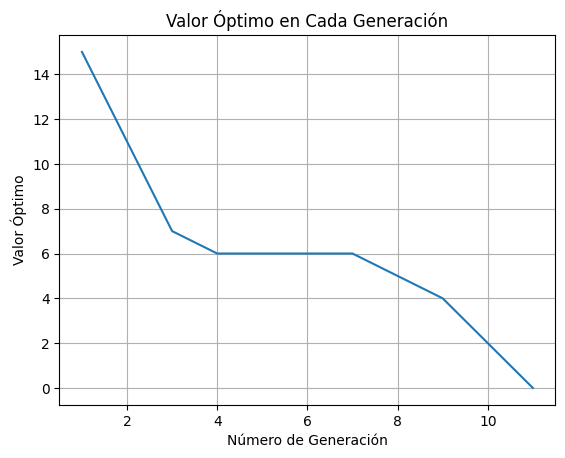

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


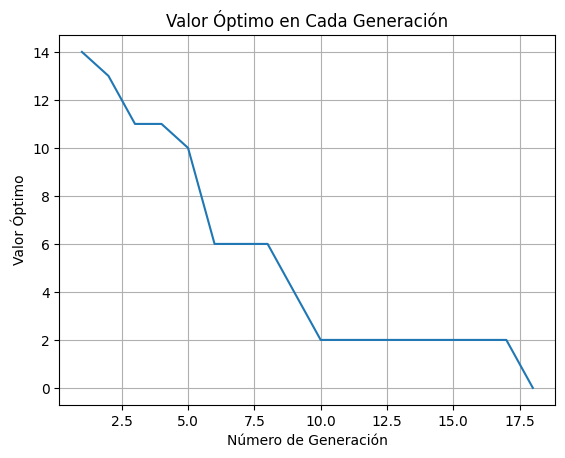

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


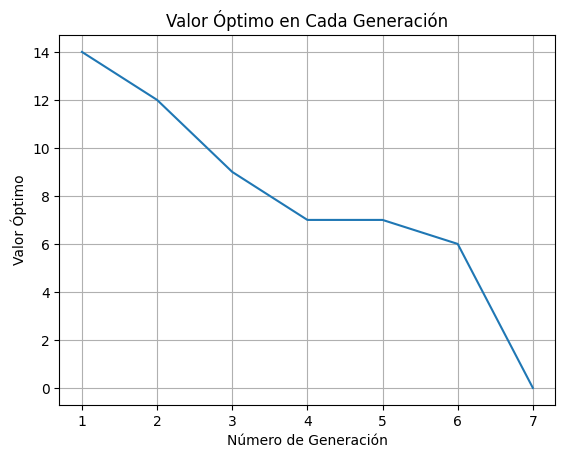

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


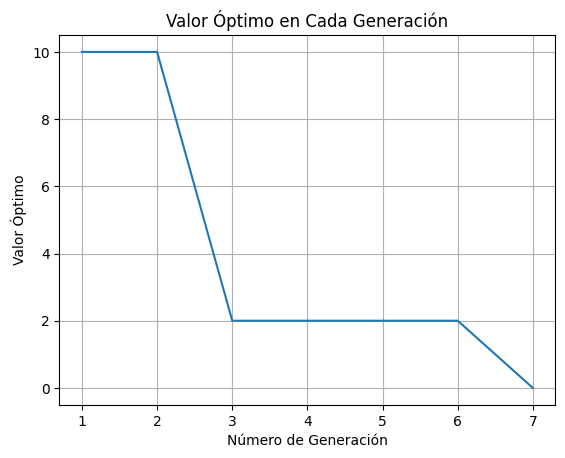

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


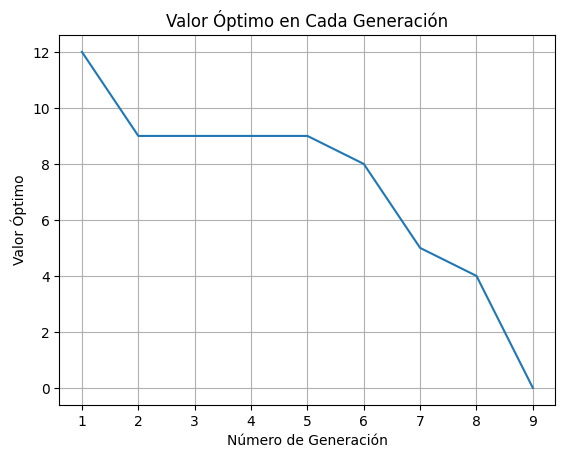

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


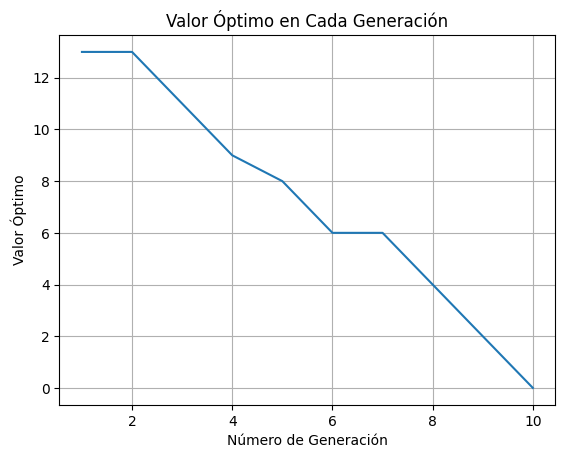

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


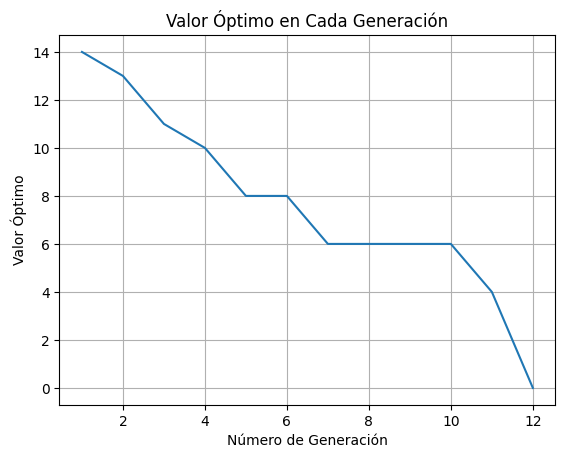

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 17
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


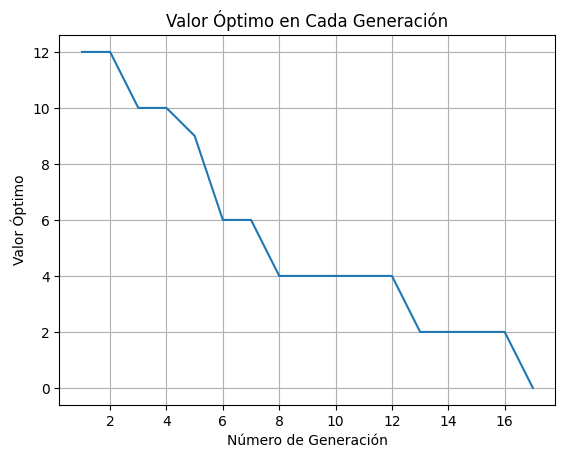

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


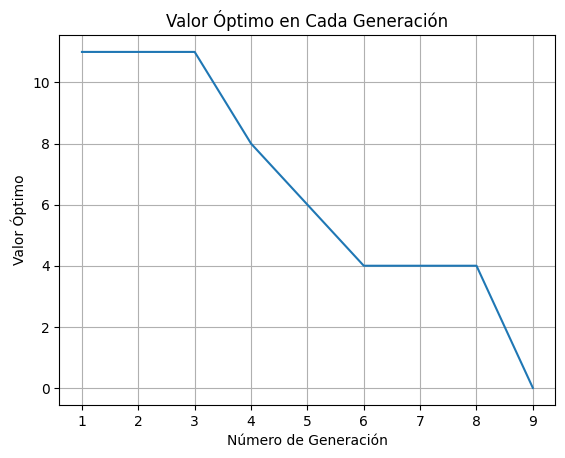

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


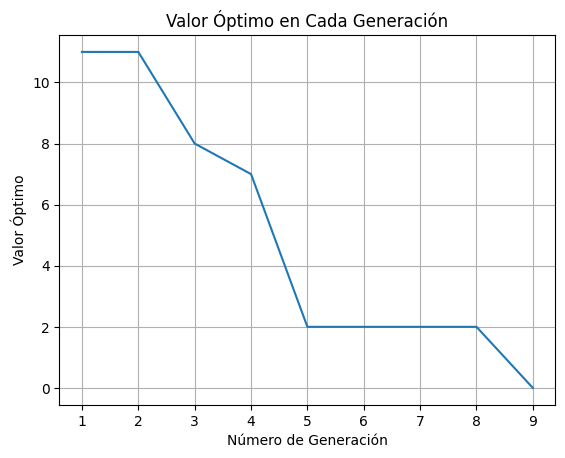

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 14
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


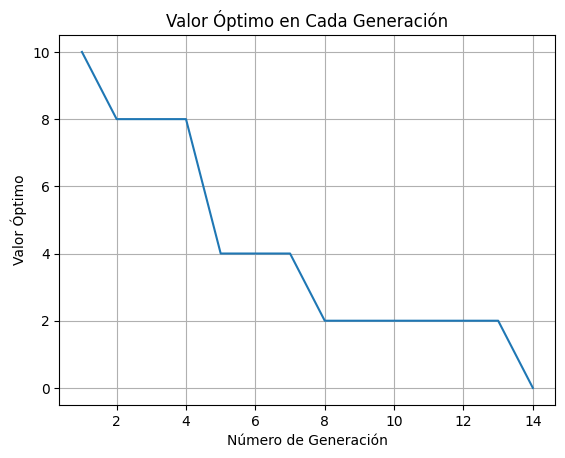

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


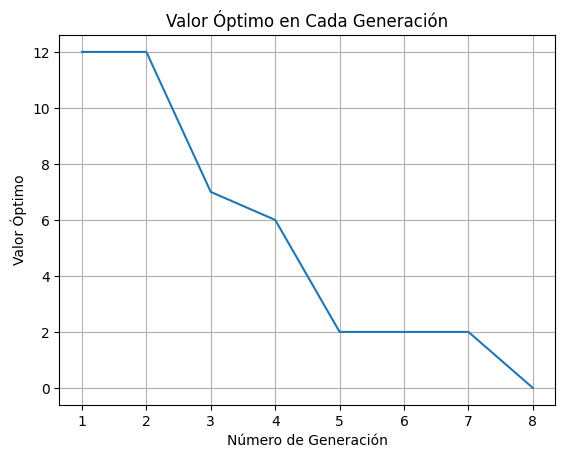

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 13
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


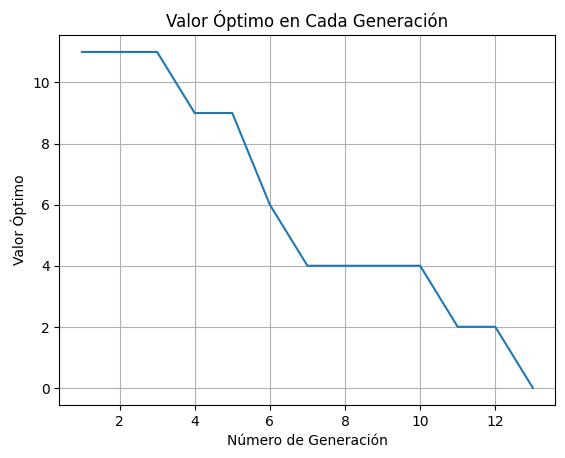

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


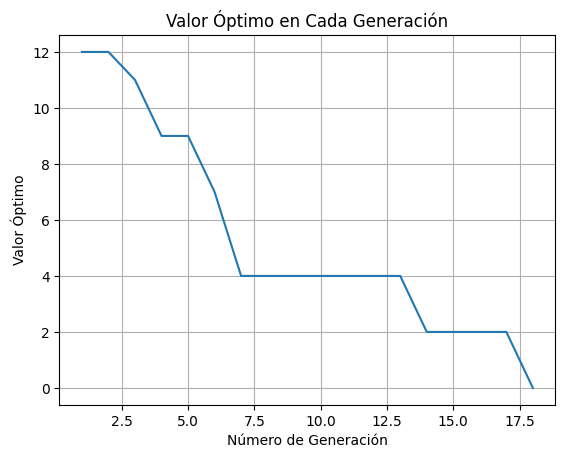

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500


In [ ]:
semillas=[1,2,3,4,5,6,7,8,9,10]

sudoku = [
    [3, 1, 9, 0, 5, 0, 4, 2, 0],
    [7, 0, 6, 0, 3, 2, 0, 1, 0],
    [4, 5, 2, 0, 1, 0, 6, 8, 3],
    [0, 7, 4, 0, 0, 0, 1, 3, 2],
    [2, 0, 1, 0, 7, 4, 5, 0, 0],
    [8, 0, 5, 1, 2, 9, 7, 6, 4],
    [5, 0, 3, 2, 9, 6, 8, 0, 1],
    [6, 2, 0, 0, 8, 1, 3, 4, 0],
    [1, 9, 8, 0, 4, 3, 0, 0, 6]
]


  tamanoPoblacion = 100
  generacionesTotales = 500

  cantidadPadres = 100
  cantidadSobrevivientes = tamanoPoblacion

  crossoverRate = [0.9,0.7,0.5]
  mutationRate = [0.4,0.2]
  for crossover in crossoverRate:
    for mutation in mutationRate:
      for semilla in semillas:
      rowCrossoverRate = 0.1
      swapMutationRate = 0.2
      reinitializationMutationRate = 0.2

      numeroElitismo = 30

      funcion = funcionObjetivo

      poblacion = inicializarPoblacion(sudoku, tamanoPoblacion)
      algoritmoGeneticoPermutaciones(funcion, poblacion, generacionesTotales, torneo, crossover, mutation, numeroElitismo)
      print(f'Se uso la configuración: \n')
      print(f'Se uso la semilla: ', semilla )
      print(f'crossoverRate: {crossover}')
      print(f'mutationRate: {mutation}')
      print(f'rowCrossoverRate: {rowCrossoverRate}')
      print(f'swapMutationRate: {swapMutationRate}')
      print(f'reinitializationMutationRate: {reinitializationMutationRate}')
      print(f'numeroElitismo: {numeroElitismo}')
      print(f'tamanoPoblacion: {tamanoPoblacion}')
      print(f'generacionesTotales: {generacionesTotales}')

Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


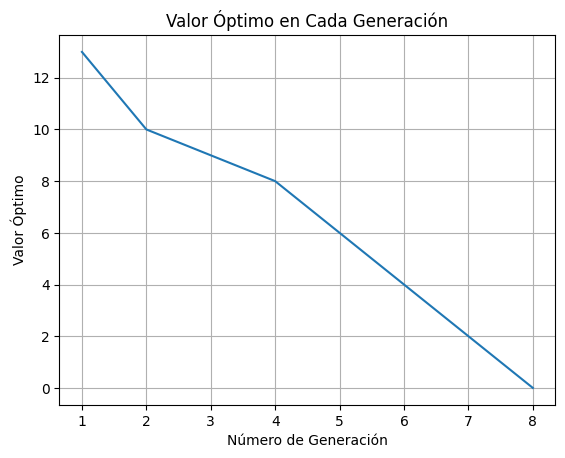

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


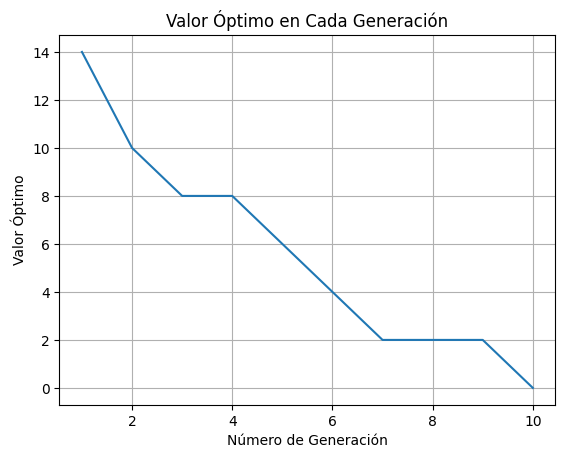

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 5
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


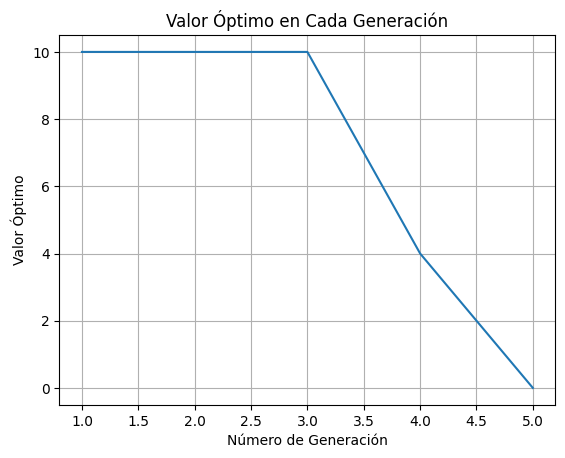

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


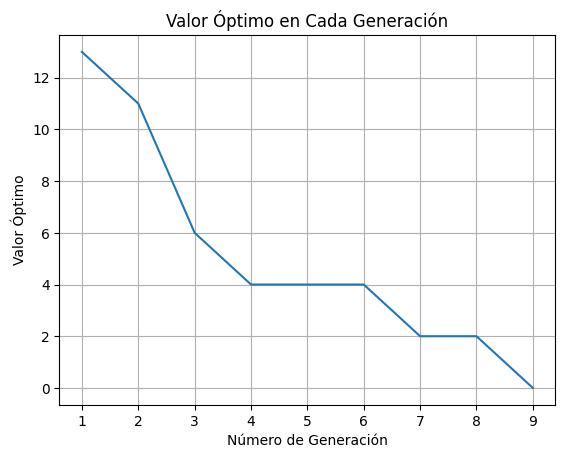

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


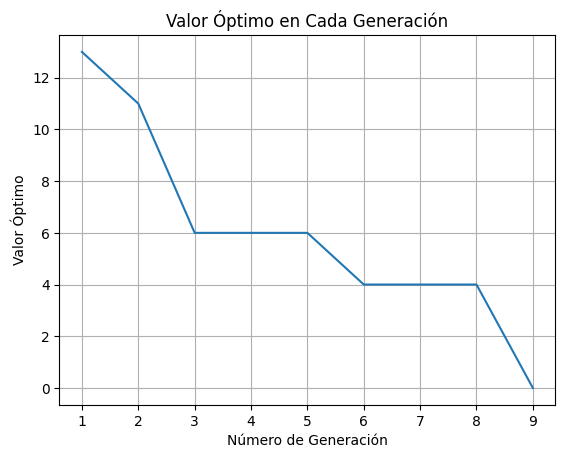

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 13
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


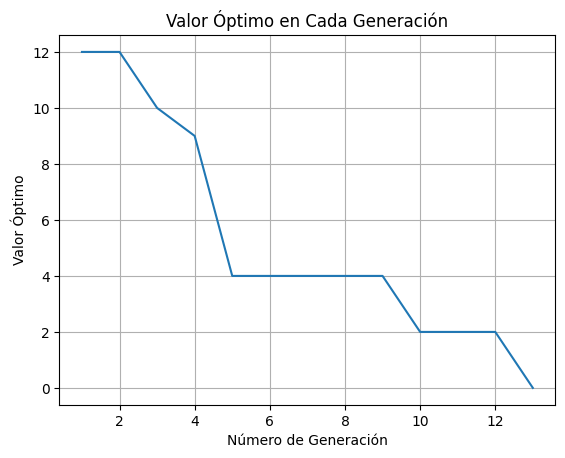

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


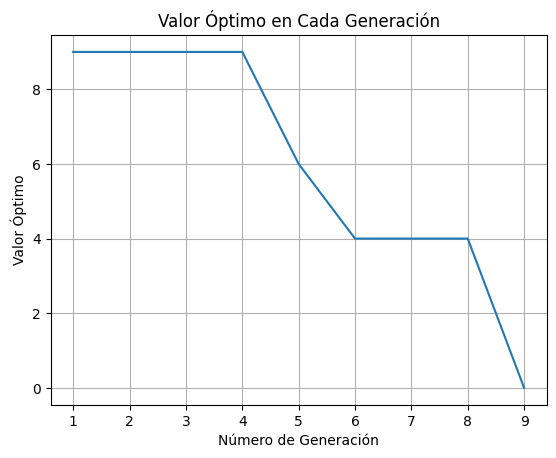

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


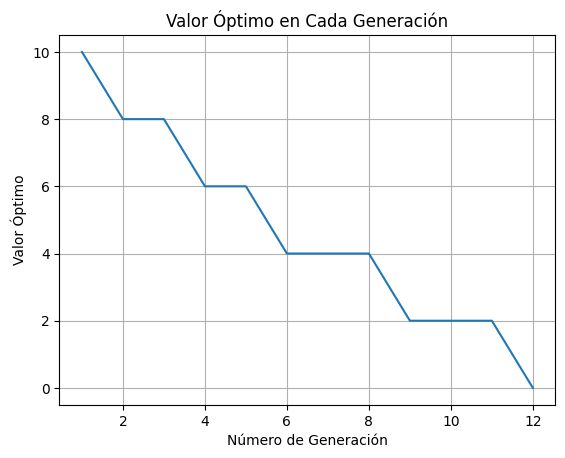

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


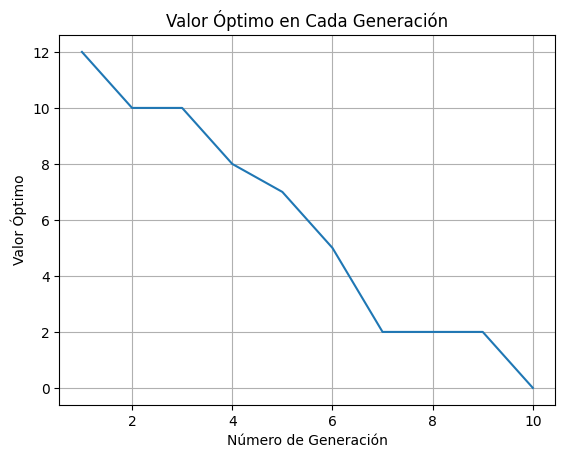

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


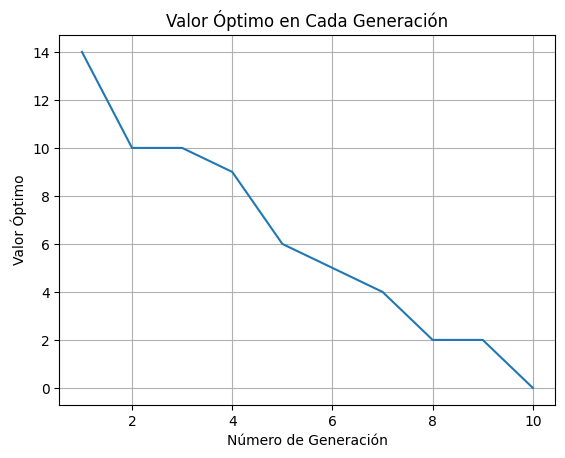

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.9
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


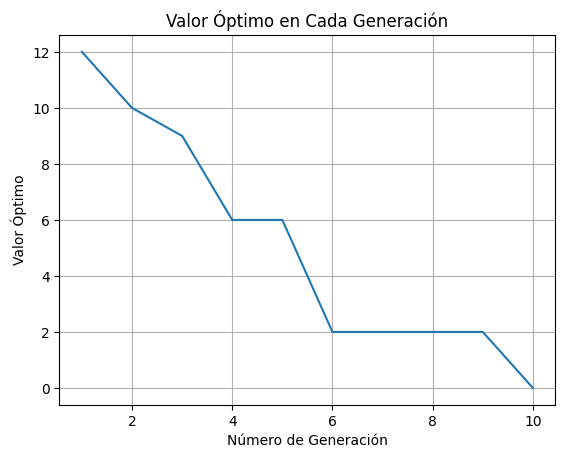

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 6
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


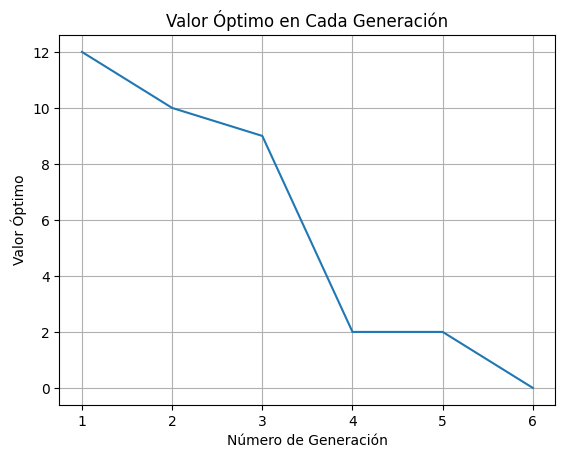

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


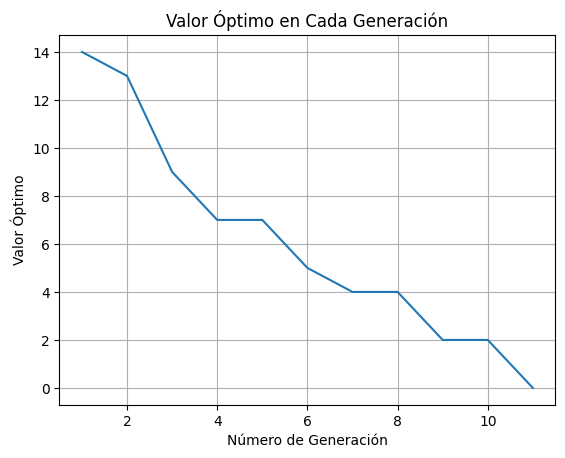

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


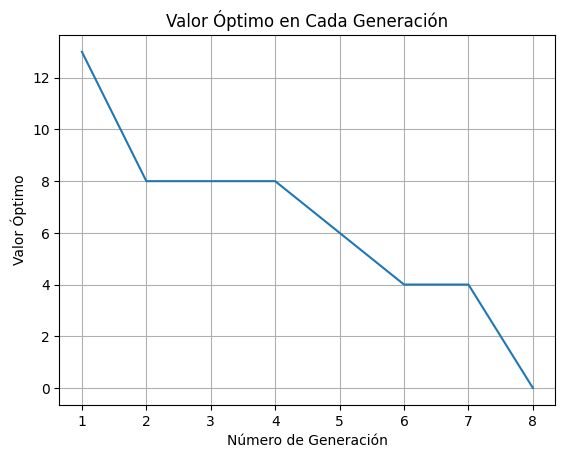

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


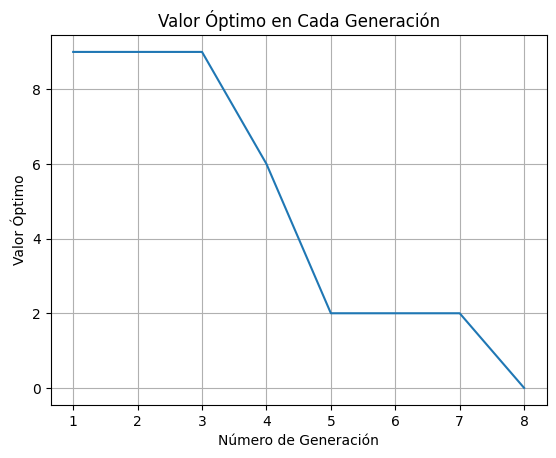

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


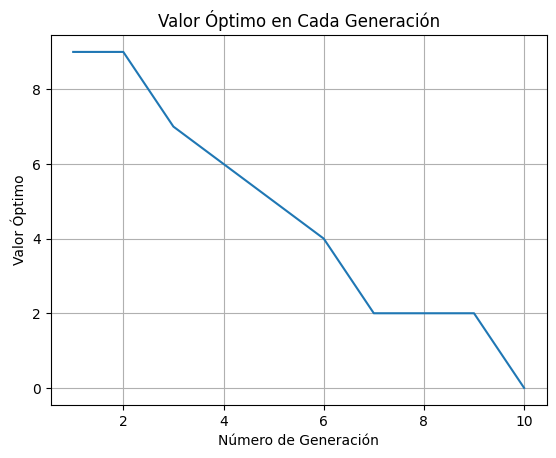

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 6
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


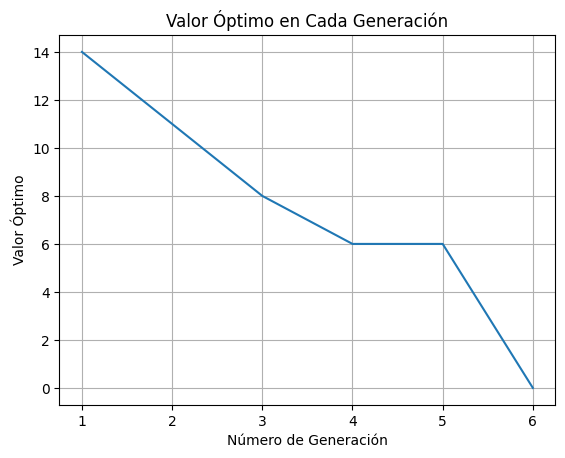

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


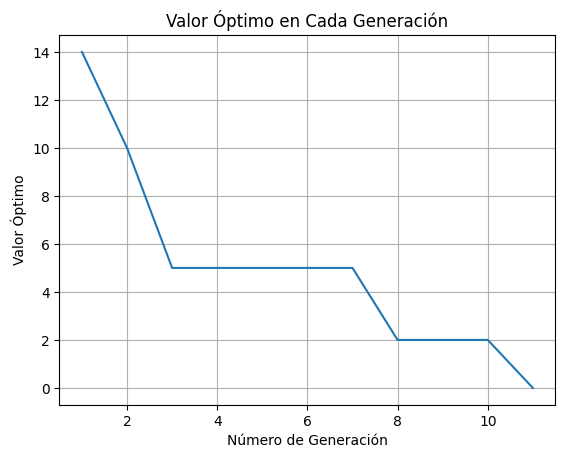

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


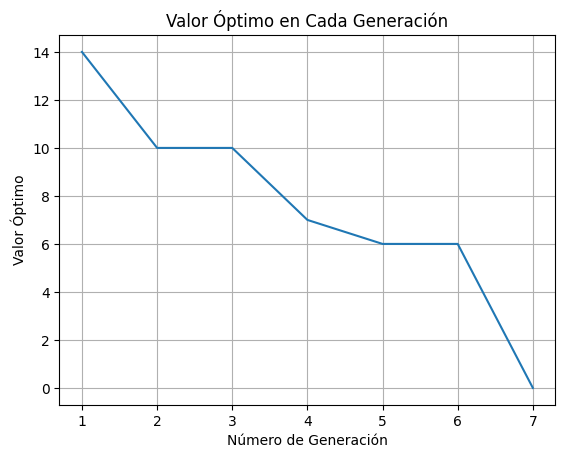

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


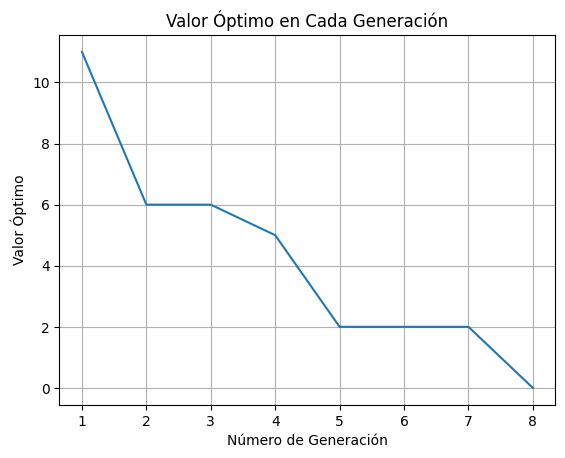

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.9
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


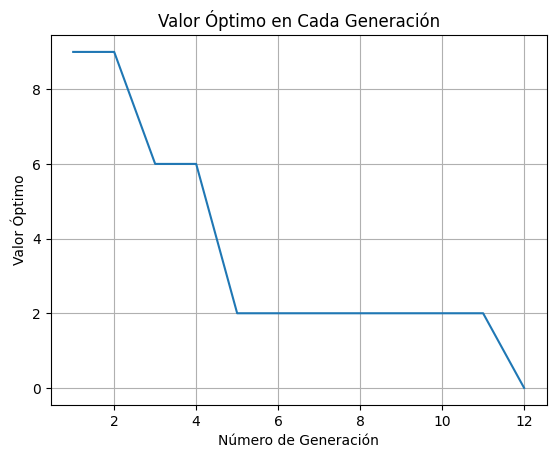

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


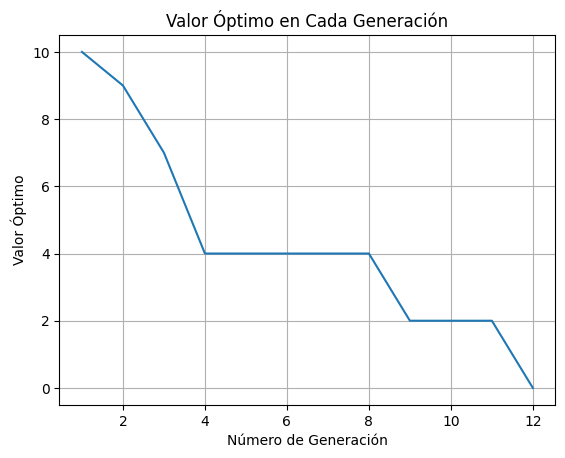

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


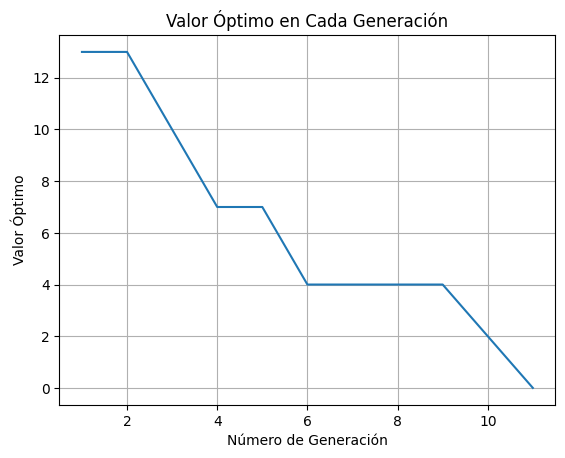

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


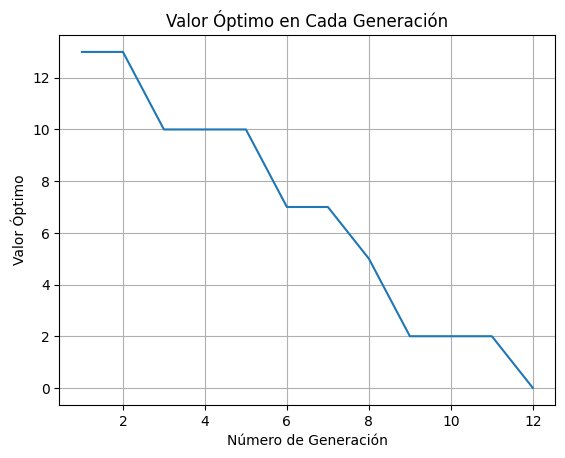

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


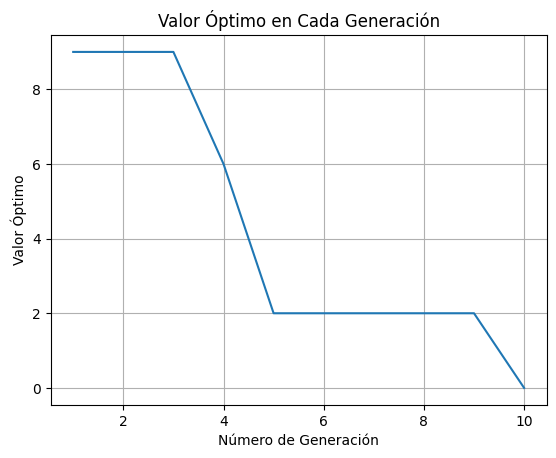

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


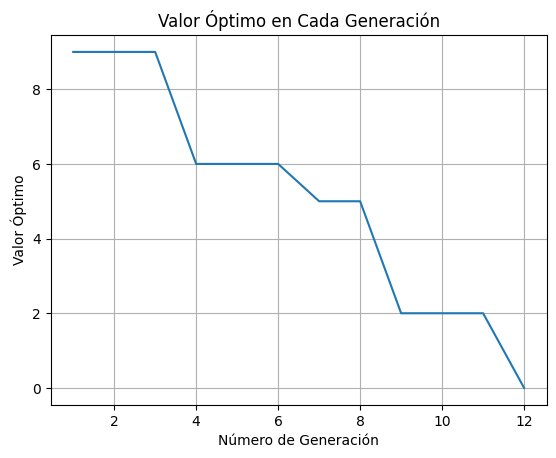

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


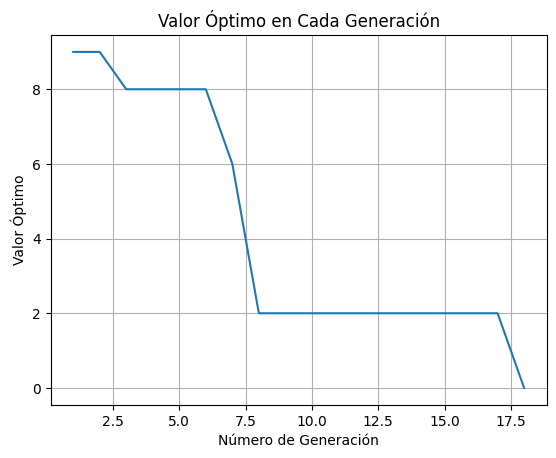

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


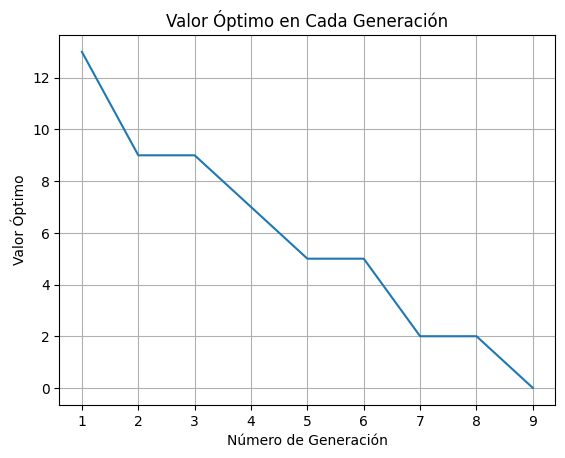

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 17
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


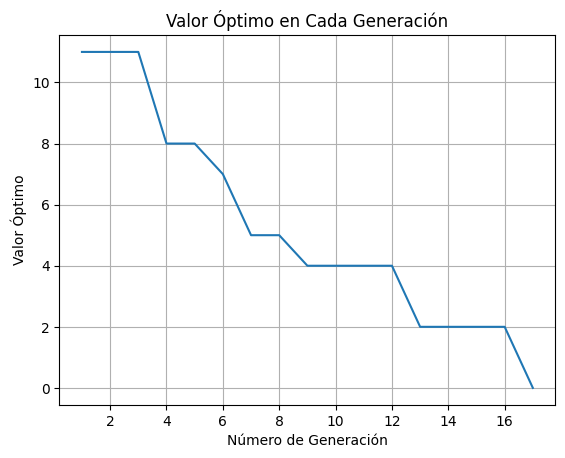

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


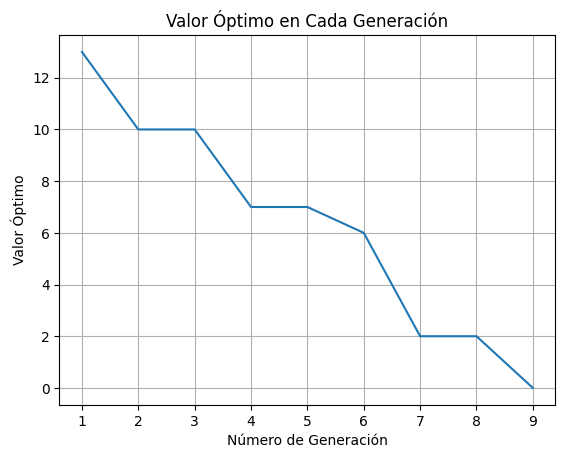

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.7
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


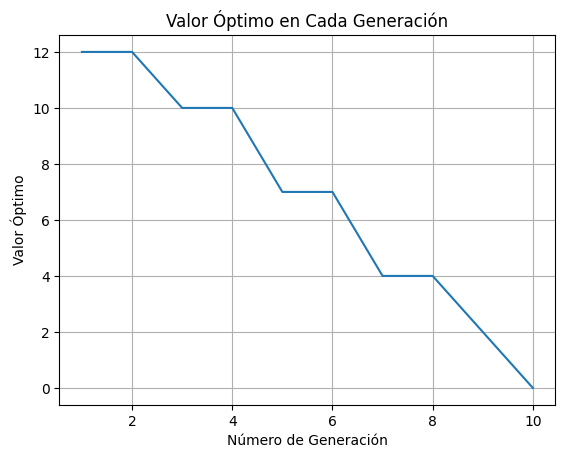

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 22
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


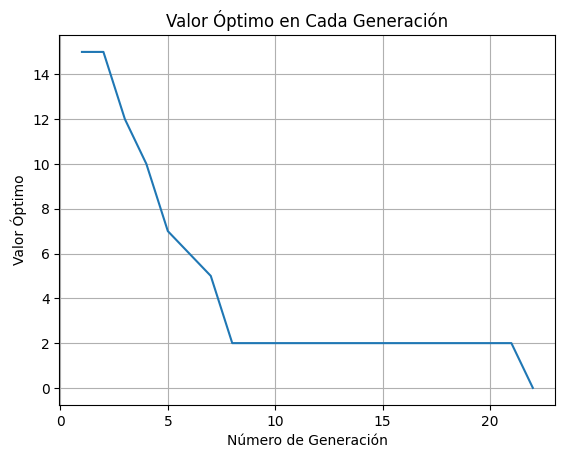

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


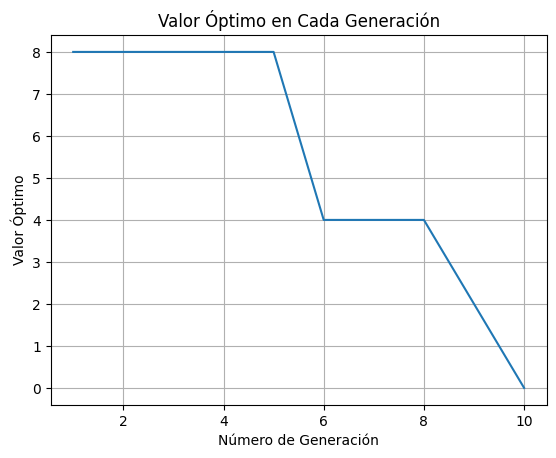

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


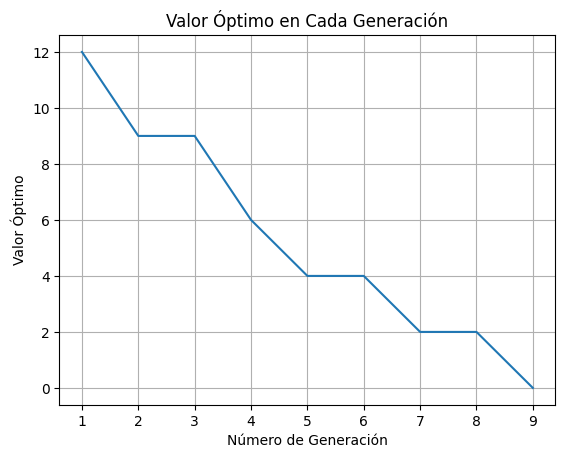

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


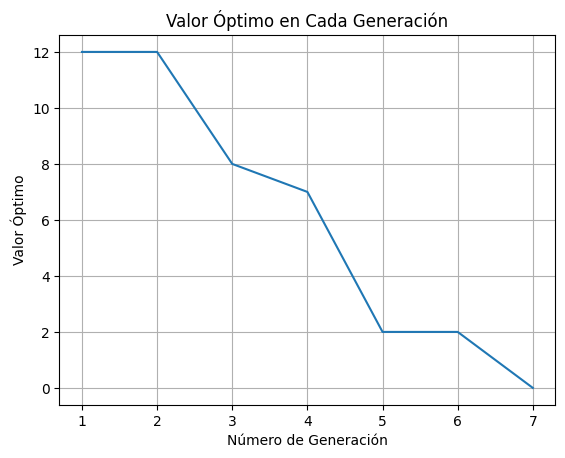

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


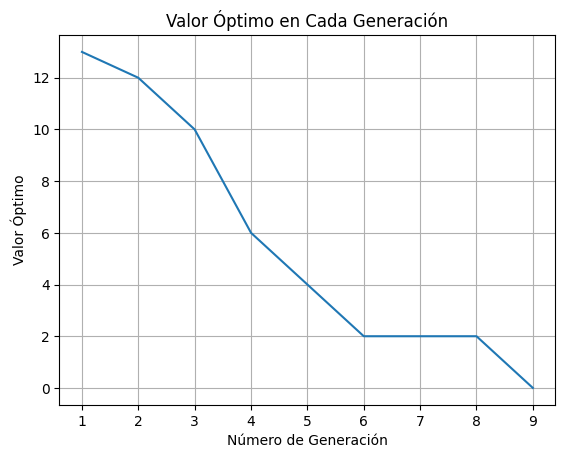

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 9
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


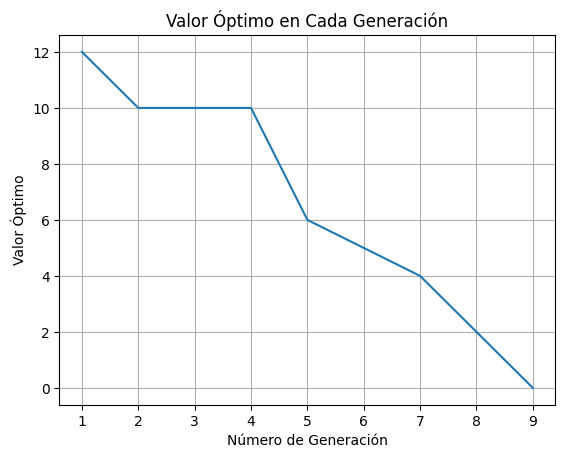

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 8
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


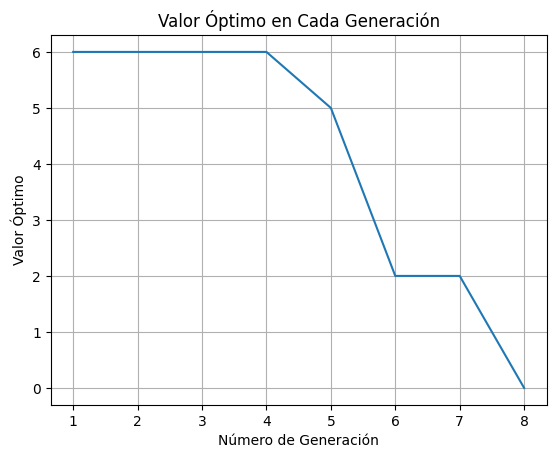

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 22
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


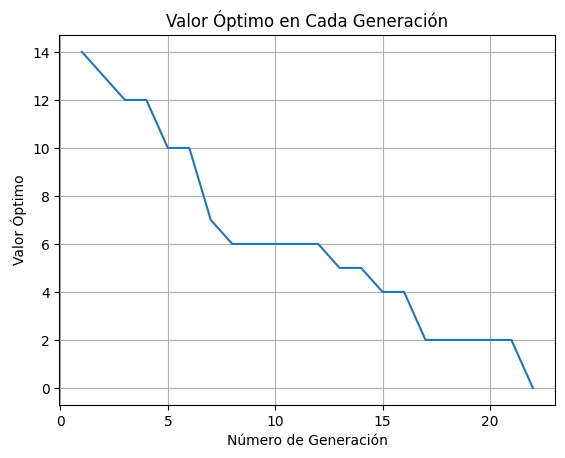

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 7
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


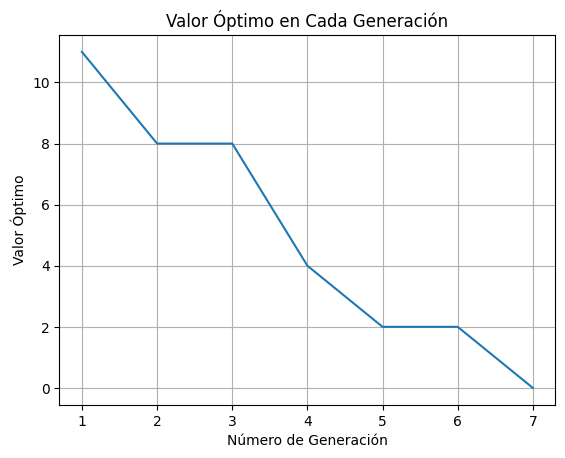

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.7
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


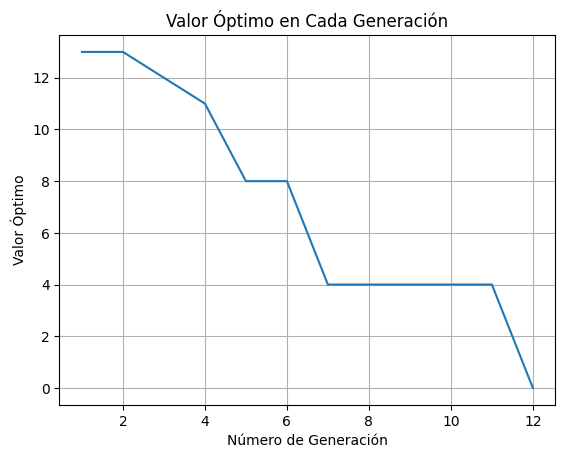

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 22
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


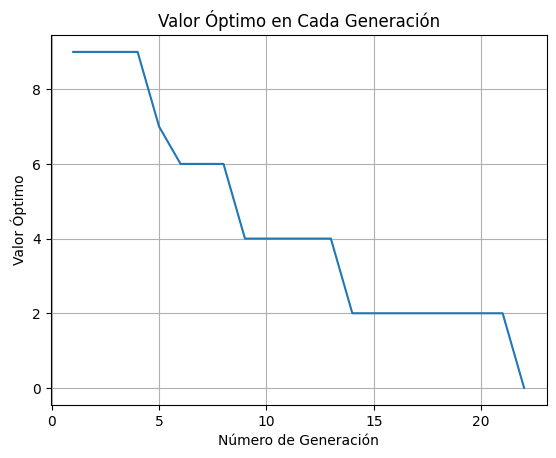

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 19
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


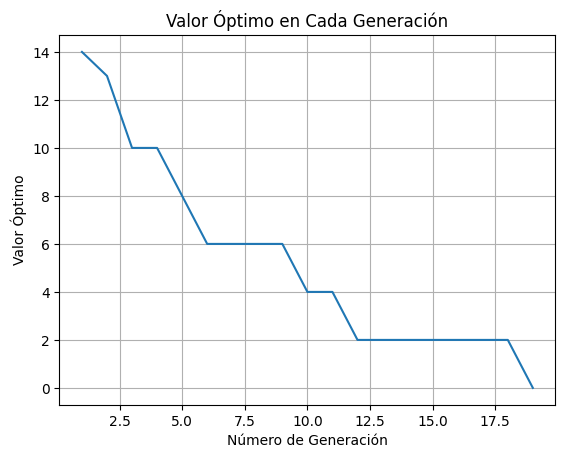

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


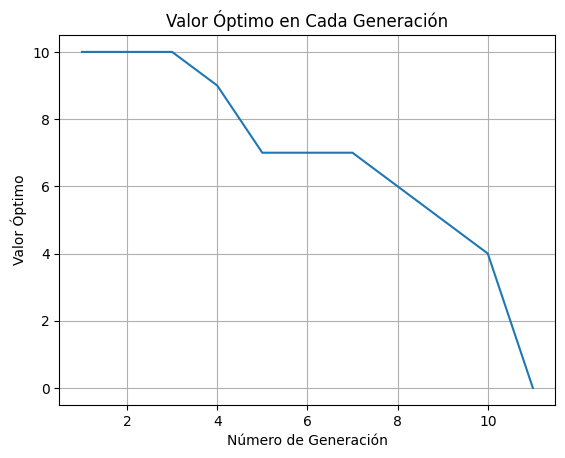

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 13
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


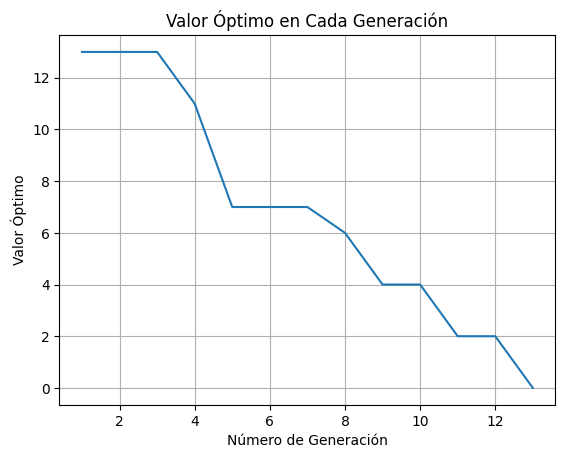

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


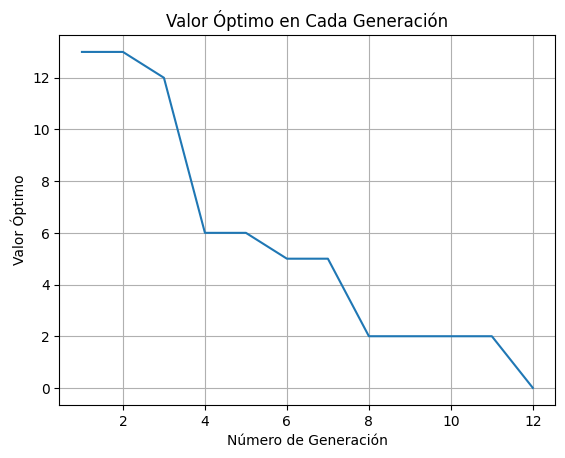

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 12
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


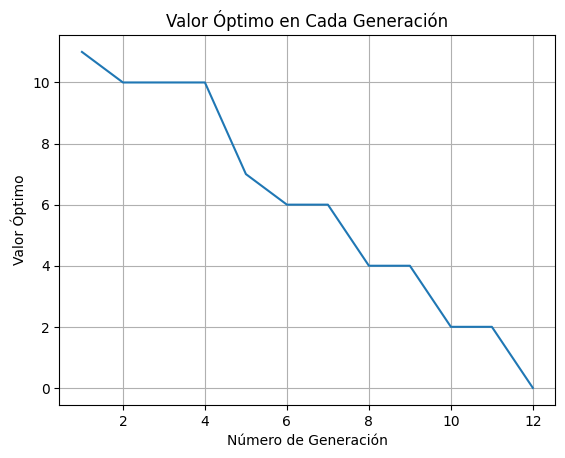

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 15
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


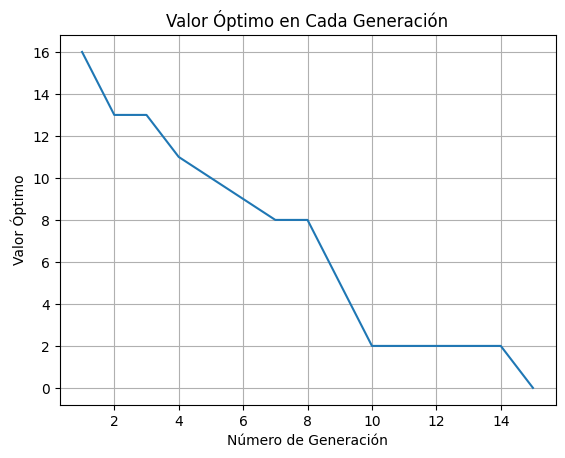

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 16
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


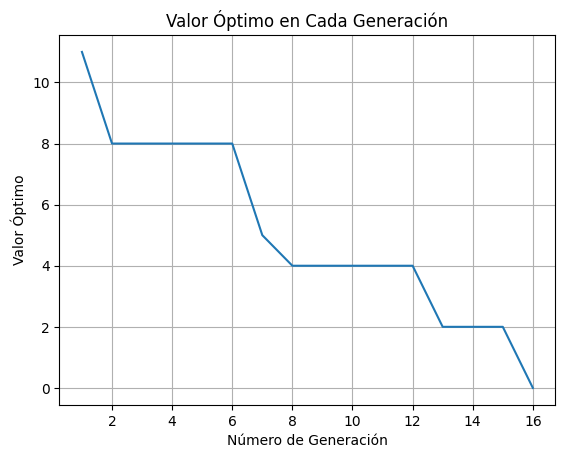

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 13
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


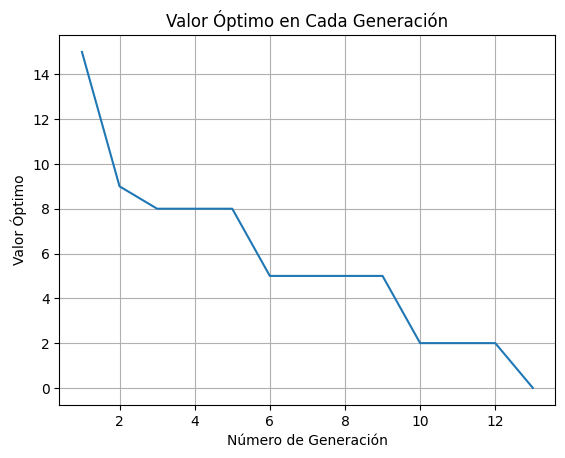

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.5
mutationRate: 0.4
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 103
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


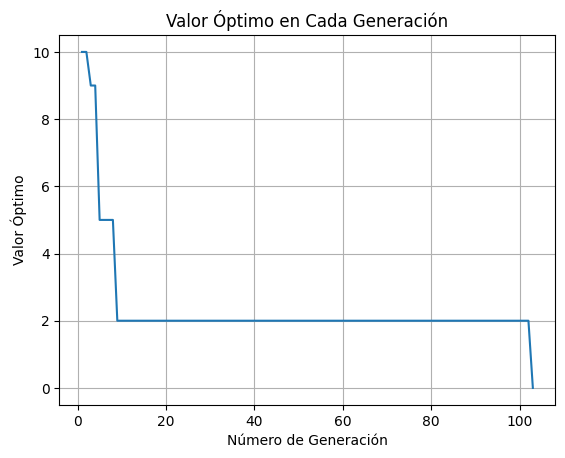

Se uso la configuración: 

Se uso la semilla:  1
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


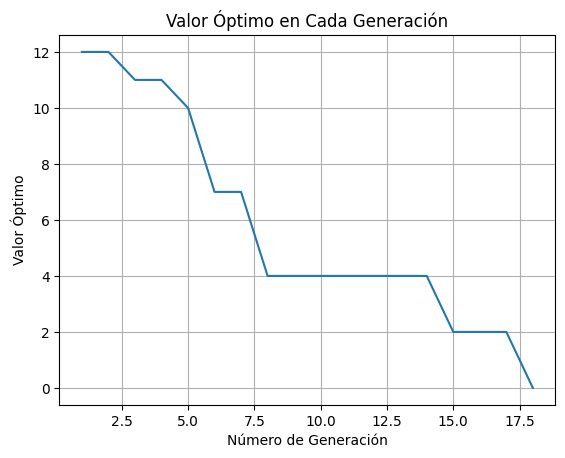

Se uso la configuración: 

Se uso la semilla:  2
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 18
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


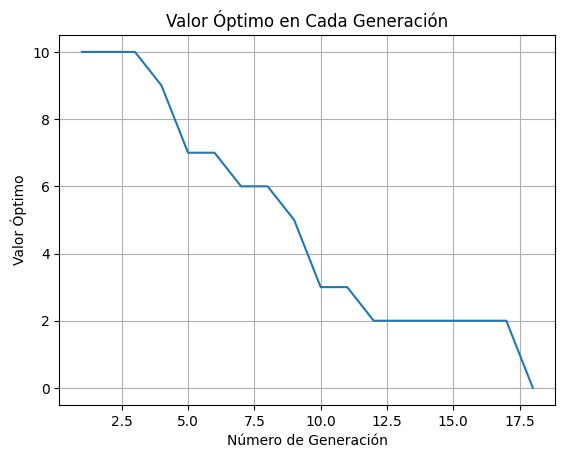

Se uso la configuración: 

Se uso la semilla:  3
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 20
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


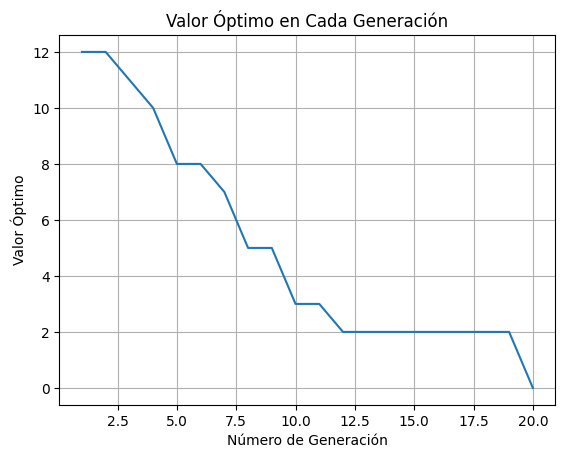

Se uso la configuración: 

Se uso la semilla:  4
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 11
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


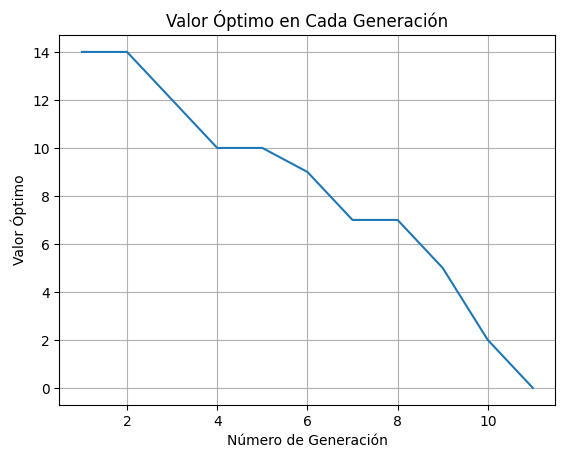

Se uso la configuración: 

Se uso la semilla:  5
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 10
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


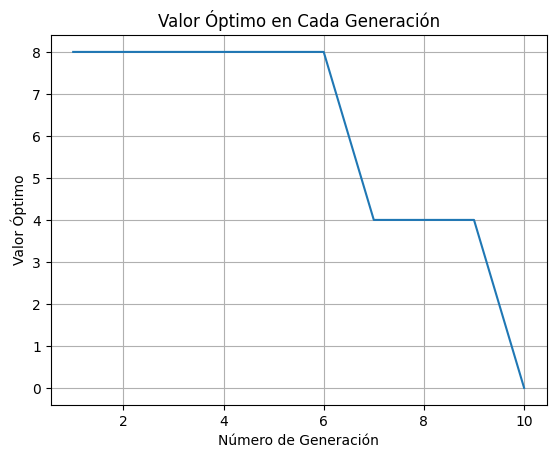

Se uso la configuración: 

Se uso la semilla:  6
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 17
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


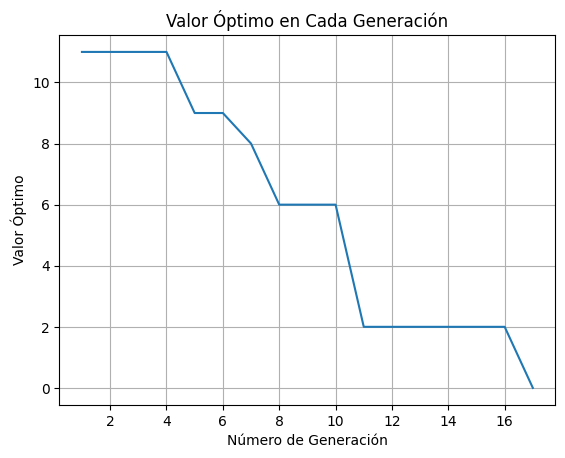

Se uso la configuración: 

Se uso la semilla:  7
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 15
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


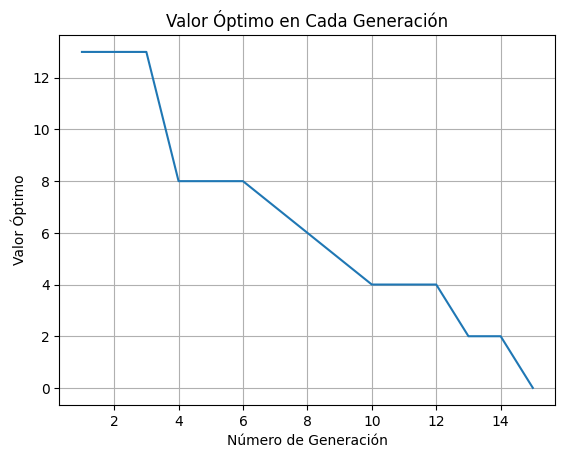

Se uso la configuración: 

Se uso la semilla:  8
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 25
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


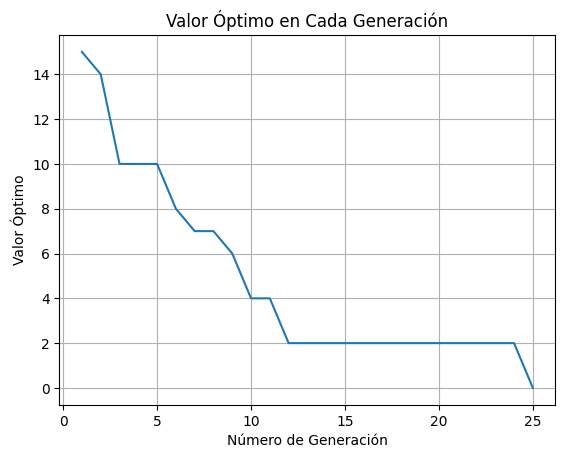

Se uso la configuración: 

Se uso la semilla:  9
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500
Creando la primera generacion:

Se ha encontrado la solucion en la generacion 19
El individuo optimo es:
[[3 1 9 6 5 8 4 2 7]
 [7 8 6 4 3 2 9 1 5]
 [4 5 2 9 1 7 6 8 3]
 [9 7 4 8 6 5 1 3 2]
 [2 6 1 3 7 4 5 9 8]
 [8 3 5 1 2 9 7 6 4]
 [5 4 3 2 9 6 8 7 1]
 [6 2 7 5 8 1 3 4 9]
 [1 9 8 7 4 3 2 5 6]]


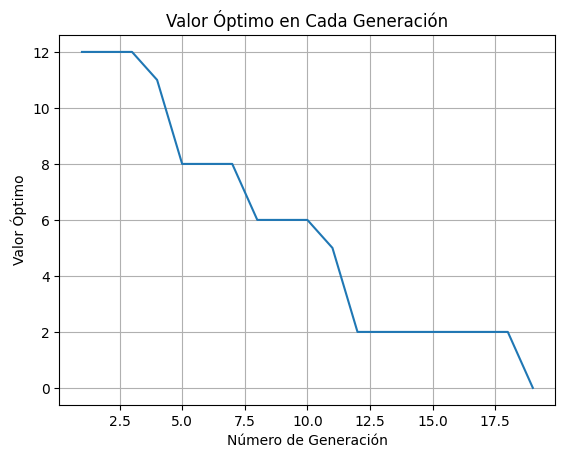

Se uso la configuración: 

Se uso la semilla:  10
crossoverRate: 0.5
mutationRate: 0.2
rowCrossoverRate: 0.1
swapMutationRate: 0.2
reinitializationMutationRate: 0.2
numeroElitismo: 30
tamanoPoblacion: 100
generacionesTotales: 500


In [ ]:
semillas=[1,2,3,4,5,6,7,8,9,10]

sudoku = [
    [3, 1, 9, 0, 5, 0, 4, 2, 0],
    [7, 0, 6, 0, 3, 2, 0, 1, 0],
    [4, 5, 2, 0, 1, 0, 6, 8, 3],
    [0, 7, 4, 0, 0, 0, 1, 3, 2],
    [2, 0, 1, 0, 7, 4, 5, 0, 0],
    [8, 0, 5, 1, 2, 9, 7, 6, 4],
    [5, 0, 3, 2, 9, 6, 8, 0, 1],
    [6, 2, 0, 0, 8, 1, 3, 4, 0],
    [1, 9, 8, 0, 4, 3, 0, 0, 6]
]


tamanoPoblacion = 100
generacionesTotales = 500

cantidadPadres = 100
cantidadSobrevivientes = tamanoPoblacion

crossoverRate = [0.9,0.7,0.5]
mutationRate = [0.4,0.2]
for crossover in crossoverRate:
  for mutation in mutationRate:
    for semilla in semillas:
      rowCrossoverRate = 0.1
      swapMutationRate = 0.2
      reinitializationMutationRate = 0.2

      numeroElitismo = 30

      funcion = funcionObjetivo

      poblacion = inicializarPoblacion(sudoku, tamanoPoblacion)
      algoritmoGeneticoPermutaciones(funcion, poblacion, generacionesTotales, torneo, crossover, mutation, numeroElitismo)
      print(f'Se uso la configuración: \n')
      print(f'Se uso la semilla: ', semilla )
      print(f'crossoverRate: {crossover}')
      print(f'mutationRate: {mutation}')
      print(f'rowCrossoverRate: {rowCrossoverRate}')
      print(f'swapMutationRate: {swapMutationRate}')
      print(f'reinitializationMutationRate: {reinitializationMutationRate}')
      print(f'numeroElitismo: {numeroElitismo}')
      print(f'tamanoPoblacion: {tamanoPoblacion}')
      print(f'generacionesTotales: {generacionesTotales}')